<a href="https://colab.research.google.com/github/r-lomba/covid-19-charts/blob/master/covid-19.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# COVID-19 Charts Notebook

This notebook generates a variety of charts starting from the latest daily data regarding COVID-19, made publicly available by Johns Hopkins University (see URL reference below).

Dataframes are created in both a cumulative and an incremental fashion starting from the original data. This allows to plot them revealing a few interesting insights.

A plotting function capable of presenting data in complex ways is the core of this notebook.

You can:

- Present data from 8 aggregated sources: Cumulative Active cases, Daily Active (new cases), Cumulative Confirmes cases, Daily Confirmed (new cases), Cumulative Recoveries, Daily Recoveries (new cases), Cumulative Fatalities, Daily Fatalities (new cases)
- Draw multiple line charts on the same plot
- Draw multiple bar chart on the same plot
- Specify linear or logarithmic scale for the Y axis
- Select single or multiple Coutries as the source of data for a particular plot
- Specify if you want to keep the Country data separated (e.g. for charts comparison) or aggregated (e.g. to check global trends)
- Generate Chart Images in PNG format inside a "charts" subdirectory, together with a simple "Index.html" page to directly show the images on a browser

### Contacts:
You can contact me here:
r.lombardelli@digitalgarage.it

### Data Source Reference:
2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE: https://github.com/CSSEGISandData/COVID-19

### Terms of use:
Please see the Terms of Use extensively described at the above link for reference

### Disclaimer:
This GitHub repo and its contents herein, including all data, mapping, and analysis is provided to the public strictly for educational and academic research purposes. It is hereby disclaimed any and all representations and warranties with respect to the Website, including accuracy, fitness for use, and merchantability. Reliance on the Website for medical guidance or use of the Website in commerce is strictly prohibited.

In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
import os
import io
import requests
import copy
import time

from datetime import datetime
from itertools import cycle, islice

%matplotlib inline

In [2]:
# PREPARES DATAFRAMES READING ORIGINAL DATA FROM LATEST FILES @ JOHNS HOPKINS GIT REPO
url_confirmed_DF = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed_orig_DF = pd.read_csv(url_confirmed_DF, sep=',')

url_deaths_DF = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deaths_orig_DF = pd.read_csv(url_deaths_DF, sep=',')

url_recovered_DF = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recovered_orig_DF = pd.read_csv(url_recovered_DF, sep=',')

In [3]:
# FORMATS A DATE
# READS A DATE IN THE ORIGINAL FORMAT IN INPUT
# RETURNS A DATE FORMATED AS 'YYYY-MM-DD'
def reformat_date(date_to_be_formatted):

    date_split = date_to_be_formatted.split('/')
    date_padded_split=[str(item).zfill(2) for item in date_split]
    date_formatted = '20' + date_padded_split[2] + '-' + date_padded_split[0] + '-' + date_padded_split[1]

    return(date_formatted)



# FORMATS A DATAFRAME
# READS DATA FOR ALL NATIONS
# RETURNS A FINAL DATAFRAME DEVELOPING HORIZONTALLY AS THE ORIGINAL DATA
# ---------------------------------------------------------------------------------------------
# DROPS 'Province/State', 'Lat' AND 'Long' COLUMNS AS NOT USED IN OUR CONTEXT
# GROUPS DATA BY NATION IF NEEDED (E.G. US OR CHINA WILL LOOSE STATE INFORMATION)
# THEREFORE MULTI-RECORDS NATIONS WILL RESULT IN HAVING JUST ONE RECORD AFTER GROUPING
# ALSO SUMS UP NUMERIC QUANTITIES BY NATION IF NEEDED (FOR THE SAME REASONS AS EXPLAINED ABOVE)
# FINALLY, RENAMES DATE COLUMNS NAMES USING THE "reformat_date" HELPER FUNCTION
def reformat_dataframe(dataframe_to_be_formatted_DF):

    dataframe_to_be_formatted_DF = dataframe_to_be_formatted_DF.drop(columns=['Province/State', 'Lat', 'Long'])
    dataframe_formatted_DF = dataframe_to_be_formatted_DF.groupby(['Country/Region']).sum()
    
    for column in dataframe_formatted_DF:
        dataframe_formatted_DF = dataframe_formatted_DF.rename(columns={column: reformat_date(column)})
    
    return(dataframe_formatted_DF)



# TOTALIZES A DATAFRAME SUMMING UP VALUES FOR A LIST OF NATIONS
# READS DATA FOR ALL NATIONS
# RETURNS A FINAL DATAFRAME DEVELOPING HORIZONTALLY AS THE ORIGINAL DATA
# CONTAINING JUST ONE RECORD PER COUNTRY WITH TOTAL VALUES
# ---------------------------------------------------------------------------------------------
# FILTERS DATAFRAME IN INPUT, WHICH HAS BEEN PREVIOUSLY FORMATTED
# EXTRACTS RECORDS FROM THE PROVIDED LIST OF NATIONS OF INTEREST TO BE TOTALIZED
def formatted_dataframe_totalize_countries(list_of_countries, dataframe_to_be_formatted_DF):

    is_in_countries = dataframe_to_be_formatted_DF.index.isin(list_of_countries)
    dataframe_formatted_DF = dataframe_to_be_formatted_DF[is_in_countries].sum().to_frame().T
    
    return(dataframe_formatted_DF)



# TRANSFORMS AN ALREADY FORMATTED DATAFRAME
# READS THE ALREADY FORMATTED DATAFRAME IN INPUT
# RETURNS A FINAL DATAFRAME CONTAINING DAILY PROGRESSIVE DATA (E.G. "NEW CASES ADDING EVERYDAY") INSTEAD OF CUMULATIVE DATA
# ---------------------------------------------------------------------------------------------
# THE ORIGINAL DATA CONTAIN A CUMULATIVE TOTAL THAT GROWS UP AT EACH NEXT SAMPLED PERIOD
# THIS FUNCTION THIS INCREASING GRANDTOTAL IN A SEQUENCE OF DAILY QUANTITIES
# ADDING UP ALL THESE DAILY QUANTITIES WILL RESULT, IN THE END, IN THE SAME GRANDTOTAL AS
# IN THE ORIGINAL DATA. THIS WILL ALLOW TO PLOT DAILY CHARTS WITH DAILY QUANTITIES
def undo_cum_dataframe(dataframe_to_be_reduced_DF):

    dataframe_reduced_DF = dataframe_to_be_reduced_DF.diff(axis=1).fillna(0).astype(int)
    
    return(dataframe_reduced_DF)



# PLOTS A SINGLE PLOT REPRESENTING THE DATA AS ASKED
# READS DATA FROM A LIST OF NATIONS PASSED IN INPUT
# THE LIST CAN BE MADE UP OF A SIGLE NATION OR MULTIPLE NATIONS
# RETURNS A SINGLE PLOT ON SCREEN CONTAINING SINGLE OR MULTIPLE LINE CHARTS
# AND/ OR SINGLE OR MULTIPLE BAR CHARTS
# THE PRESENTED CHARTS CAN BE MULTIPLE SPLITS ORIGINTING FROM EVERY SINGLE
# NATION IN THE LIST OF COUNTRIES (E.G. TO PERFORM COMPARISON)
# OR CAN BE SINGLE SUMMED-UP ENTITES ORIGINATING FROM ALL THE SUM OF
# ALL THE NATIONS IN THE LIST OF COUNTRIES (E.G. TO CHECK GLOBAL TRENDS)
# ALSO, THE GENERATED PLOT IS SAVED IN ".png" FORMAT IN THE "charts" SUBDIR
# ---------------------------------------------------------------------------------------------
# THIS PLOTTING UTILITY FUNCTION TAKES IN INPUT:
# A LIST OF NATIONS
# A STARTING DATE OF INTEREST (FORMATTED "YYYY-MM-DD")
# A TITLE FOR THE FINAL CHART
# A SCALE FOR THE Y AXIS (E.G. "plain" OR "log")
# A DICTIONARY OF FORMATTED DATAFRAMES CONTAINING THE DATA TO BE PLOTTED
# A DICTIONARI OF CHART TYPES THAT WE WANT TO USE TO PLOT EACH OF THE DATAFRAMES SPECIFIED ABOVE
# A FLAG SPECIFYING IF WE WANT TO GROUP THE SINGLE CHARTS FOR ALL NATIONS (E.G. "Y" OR "N")
def plot_complete_chart(list_of_countries,
                        start_date,
                        title,
                        scale,
                        dict_of_dataframes,
                        dict_of_charttypes,
                        flg_totalize_countries):

    # CHART SCALE TO BE USED, PLAIN OR LOGARITHMIC
    if(scale == 'plain'):
        logy=False
    else:
        logy=True
    
    # INITIALIZES FILE NAME TO BE USED WHEN SAVING CHART TO FILESYSTEM
    filename = title.replace('\n','').replace('\t','').replace(' ', '_')
    
    # CREATES EMPTY HELPER DATAFRAME TO BE USED IF WE HAVE BAR CHARTS TO BE PLOTTED
    flg_barcharts = 0
    d_barcharts = pd.DataFrame()

    # COMMON FIGURE FOR ALL PLOTS, COMMON AX. COULD BE "f = plt.figure()" IF SINGLE DATAFRAME PLOT
    f, ax = plt.subplots()
    
    # AXIS LABELS
    ax.set_xlabel("Date", size=12)
    ax.set_ylabel("Number of Cases", size=12)
    
    # SETS CHART TITLE AND OTHER PARAMS
    plt.title(title, color='black', size=18)
    #plt.suptitle(title, color='black', size=18)
    #plt.subplots_adjust(top=0.8)
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.tight_layout()

    # IF WE REQUESTED A SEPARATE CHART FOR EACH COUNTRY
    # LET'S NORMALLY LOOP THROUGH THE LIST
    if flg_totalize_countries == 'N':
        for i, country in enumerate(list_of_countries):
        
            for key in dict_of_dataframes.keys(): # LOOPS OVER DATAFRAMES PASSED IN INPUT
                kind = dict_of_charttypes[key] # EXTRACTS DESIRED CHART TYPE FOR THIS DATAFRAME, FROM THE CORRESPONDING KEY IN CHART TYPES DICTIONARY
            
                if kind == 'line': # LINE CHART
                    d = dict_of_dataframes[key][dict_of_dataframes[key].index.isin([country])].T
                    d = d.rename(columns={d.columns[0]: country + ' - ' + key})
                    d = d[d.index > start_date]

                    # LINE CHARTS ARE PLOTTED AS THEY FLOW IN
                    fig_to_be_saved = d.plot(kind=kind, logy=logy, legend=True, figsize=(15,10), grid=True, rot=90, ax=ax)
            
                else: # BAR CHART
                
                    flg_barcharts = 1 # HOUSTON, WE HAVE A BARCHART
                
                    d_tmp = dict_of_dataframes[key][dict_of_dataframes[key].index.isin([country])].T
                    d_tmp = d_tmp.rename(columns={d_tmp.columns[0]: country + ' - ' + key})
                    d_tmp = d_tmp[d_tmp.index > start_date]

                    d_barcharts = pd.concat([d_barcharts, d_tmp], axis=1)

    # IF INSTEAD WE REQUESTED TO COLLAPSE MULTIPLE COUNTRIES IN JUST ONE CHART SUMMING THEIR DATA UP
    # LET'S DO SOME PREPARATIONS ON THE ORIGINAL DATA FIRST
    else:
        
        for key in dict_of_dataframes.keys(): # LOOPS OVER DATAFRAMES PASSED IN INPUT
            kind = dict_of_charttypes[key] # EXTRACTS DESIRED CHART TYPE FOR THIS DATAFRAME, FROM THE CORRESPONDING KEY IN CHART TYPES DICTIONARY
            totalized_by_countries_dataframe = formatted_dataframe_totalize_countries(list_of_countries, dict_of_dataframes[key])
            
            if kind == 'line': # LINE CHART
                d = totalized_by_countries_dataframe[totalized_by_countries_dataframe.index.isin(['0'])].T
                d = d.rename(columns={d.columns[0]: 'Many Countries' + ' - ' + key})
                d = d[d.index > start_date]

                # LINE CHARTS ARE PLOTTED AS THEY FLOW IN
                fig_to_be_saved = d.plot(kind=kind, logy=logy, legend=True, figsize=(15,10), grid=True, rot=90, ax=ax)

            else: # BAR CHART
                
                flg_barcharts = 1 # HOUSTON, WE HAVE A BARCHART
                
                d_tmp = totalized_by_countries_dataframe[totalized_by_countries_dataframe.index.isin(['0'])].T
                d_tmp = d_tmp.rename(columns={d_tmp.columns[0]: 'Many Countries' + ' - ' + key})
                d_tmp = d_tmp[d_tmp.index > start_date]

                d_barcharts = pd.concat([d_barcharts, d_tmp], axis=1)
                
    # IF WE HAVE PROCESSED BAR CHARTS IN OUR MAIN LOOP, WE HAVE TO PLOT THEM OUT OF IT
    # BECAUSE IN THE MAIN LOOP WE JUST CONCATENATE DATAFRAMES
    if flg_barcharts == 1:
        fig_to_be_saved = d_barcharts.plot(kind='bar', logy=logy, legend=True, figsize=(15,10), grid=True, rot=90, stacked=False, ax=ax)
            
    # SAVES RESULTING BAR CHARTS
    fig_to_be_saved = fig_to_be_saved.get_figure()
    fig_to_be_saved.savefig('charts/' + filename + '.png')

    plt.show()



# PLOTS A SINGLE PLOT PRESENTING (AS BIG FONT NUMBERS) THE GRANDTOTALS SUMMARY OF:
# - CONFIRMED CASES
# - ACTIVE CASES
# - RECOVERED CASES
# - DEATHS
# ALSO, THE GENERATED PLOT IS SAVED IN ".png" FORMAT IN THE "charts" SUBDIR
# ---------------------------------------------------------------------------------------------
# THIS PLOTTING UTILITY FUNCTION TAKES IN INPUT:
# A LIST OF NUMBERS TO PLOT (E.G. CONFIRMED, ACTIVE, RECOVERED, DEATHS)
# A TITLE FOR THE FINAL CHART
def plot_summary_headings_chart(list_of_numbers,
                                list_of_subtitles,
                                list_of_colors,
                                list_of_textcolors,
                                title):

    # INITIALIZES FILE NAME TO BE USED WHEN SAVING CHART TO FILESYSTEM
    filename = title.replace('\n','').replace('\t','').replace(' ', '_')[:200]
    
    f, (ax1) = plt.subplots(1, len(list_of_numbers), figsize=(15,4), squeeze=False)
    
    # SETS CHART TITLE AND OTHER PARAMS
    #f.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(top=0.4)
    f.suptitle(title, color='black', size=18, y=0.98)
    #plt.title(title, color='black', size=18)
    #plt.suptitle(title, color='black', size=18)
    #plt.subplots_adjust(top=0.8)
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.tight_layout()

    for i, number in enumerate(list_of_numbers):
        
        ax1[0,i].set_title(list_of_subtitles[i], color='black', size=16)
        ax1[0,i].set_facecolor(list_of_colors[i])
        ax1[0,i].text(0.1, 0.25, list_of_numbers[i], fontsize=40, color=list_of_textcolors[i])

        # REMOVE TICKS FROM BOXES
        ax1[0,i].tick_params(
        axis='both',            # CHANGES APPLY TO BOTH AXIS, ELSE "x" OR "y"
        which='both',           # BOTH MAJOR AND MINOR TICKS AFFECTED
        bottom=False,           # BOTTOM EDGE TICKS OFF
        top=False,              # TOP EDGE TICKS OFF
        left=False,             # LEFT EDGE TICKS OFF
        labelbottom=False,      # BOTTOM EDGE LABELS OFF
        labelleft=False)        # LEFT EDGE LABELS OFF
            
    # SAVES RESULTING SUMMARY
    plt.savefig('charts/' + filename + '.png')

    plt.show()

In [4]:
#############################################################
##
## AGGREGATED DATAFRAMES - CUMULATIVE AND DAILY QUANTITIES
##
#############################################################

# PROPERLY REFORMATS CUMULATIVE CONFIRMED TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
confirmed_DF = reformat_dataframe(confirmed_orig_DF)

# MAKES SURE ALL THE NUMERIC COLUMNS IN CONFIRMED DATAFRAME ARE "Int64" (CORRECT ISSUES IN THE DATASET SINCE 2020/03/07)
for i, key in enumerate(confirmed_DF.keys()):
    if (i >= 2):
        confirmed_DF[key] = confirmed_DF[key].fillna(0).astype(np.int64)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE CONFIRMED TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_confirmed_DF = undo_cum_dataframe(confirmed_DF)

# PROPERLY REFORMATS CUMULATIVE DEATHS TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
deaths_DF = reformat_dataframe(deaths_orig_DF)

# MAKES SURE ALL THE NUMERIC COLUMNS IN DEATHS DATAFRAME ARE "Int64" (CORRECT ISSUES IN THE DATASET SINCE 2020/03/07)
for i, key in enumerate(deaths_DF.keys()):
    if (i >= 2):
        deaths_DF[key] = deaths_DF[key].fillna(0).astype(np.int64)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE DEATHS TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_deaths_DF = undo_cum_dataframe(deaths_DF)

# PROPERLY REFORMATS CUMULATIVE RECOVERIES TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
recovered_DF = reformat_dataframe(recovered_orig_DF)

# MAKES SURE ALL THE NUMERIC COLUMNS IN RECOVERIES DATAFRAME ARE "Int64" (CORRECT ISSUES IN THE DATASET SINCE 2020/03/07)
for i, key in enumerate(recovered_DF.keys()):
    if (i >= 2):
        recovered_DF[key] = recovered_DF[key].fillna(0).astype(np.int64)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE RECOVERIES TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_recovered_DF = undo_cum_dataframe(recovered_DF)

# PROPERLY REFORMATS CUMULATIVE ACTIVE CASES TOTAL DATAFRAME
# THIS STAT IS OF COURSE THE SUBTRACTION OF (CONFIRMED - (RECOVERED + DEATHS))
# ONE RECORD PER COUNTRY
active_DF = (confirmed_DF.sub(recovered_DF)).sub(deaths_DF)

# MAKES SURE ALL THE NUMERIC COLUMNS IN ACTIVE CASES DATAFRAME ARE "Int64" (CORRECT ISSUES IN THE DATASET SINCE 2020/03/07)
for i, key in enumerate(active_DF.keys()):
    if (i >= 2):
        active_DF[key] = active_DF[key].fillna(0).astype(np.int64)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE ACTIVE CASES TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_active_DF = undo_cum_dataframe(active_DF)

In [5]:
# WORLD COUNTRIES UPDATED LIST OF ALL NATIONS AVAILABLE IN LATEST DATA @ JOHNS HOPKINS
list_of_countries_world = confirmed_DF.index.tolist()

# WORLD COUNTRIES EXCEPT CHINA. NEED TO START FROM A DEEP COPY OF THE ORIGINAL LIST TO AVOID CONFLICTS
list_of_countries_world_nochina = copy.deepcopy(list_of_countries_world)
list_of_countries_world_nochina.remove('Mainland China')

# EUROPEAN COUNTRIES LIST IS HARDCODED. UPDATE MANUALLY IF NEEDED
list_of_countries_europe = ['Austria',
                            'Belgium',
                            'Croatia',
                            'Czech Republic',
                            'Denmark',
                            'Estonia',
                            'Finland',
                            'France',
                            'Germany',
                            'Greece',
                            'Ireland',
                            'Italy',
                            'Latvia',
                            'Lithuania',
                            'Luxembourg',
                            'Netherlands',
                            'Portugal',
                            'Romania',
                            'Spain',
                            'Sweden',
                            'Norway',
                            'Switzerland',
                            'UK',
                            'San Marino',
                            'Monaco']

# EUROPEAN COUNTRIES EXCEPT ITALY. NEED TO START FROM A DEEP COPY OF THE ORIGINAL LIST TO AVOID CONFLICTS
list_of_countries_europe_noitaly = copy.deepcopy(list_of_countries_europe)
list_of_countries_europe_noitaly.remove('Italy')

# POPULATES CHART TYPES DICTIONARY FOR EACH OF THE POSSIBLE DATAFRAMES TYPES WE ARE GOING TO PLOT LATER
# VALID TYPES ARE 'line' AND 'bar'
# DICTIONARY KEYS MUST MATCH THE CORRESPONDING DATAFRAME KEY THAT WE'LL USE LATER WHEN PLOTTING THE CHARTS
dict_of_charttypes = {'Daily Confirmed': 'bar',
                      'Daily Recovered': 'bar',
                      'Daily Fatalities': 'bar',
                      'Daily Active': 'bar',
                      'Cumulative Confirmed': 'line',
                      'Cumulative Recovered': 'line',
                      'Cumulative Fatalities': 'line',
                      'Cumulative Active': 'line'}

In [6]:
# CREATES WORKING DIRECTORY IF IT DOESN'T EXIST
path = os.getcwd()

try:
    os.mkdir(path + '/charts')

except OSError:
    print ('Directory ./charts already exists, proceed anyway')

else:
    print ('Successfully created Directory ./charts')

Directory ./charts already exists, proceed anyway


In [7]:
# CALCULATES WORLD GRANDTOTALS TO BE SHOWN ON TOP OF THE CHARTS LIST
active_grandtotal = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_active_DF).sum(axis=1))[0]
confirmed_grandtotal = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_confirmed_DF).sum(axis=1))[0]
recovered_grandtotal = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_recovered_DF).sum(axis=1))[0]
deaths_grandtotal = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_deaths_DF).sum(axis=1))[0]

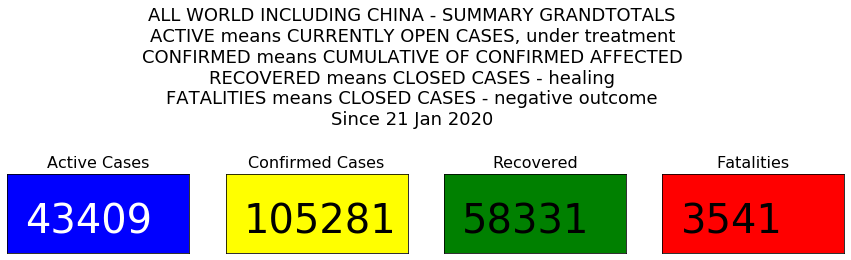

In [8]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN A LIST HOLDING THEM ALL
summary_figures = [active_grandtotal, confirmed_grandtotal, recovered_grandtotal, deaths_grandtotal]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'ALL WORLD INCLUDING CHINA - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

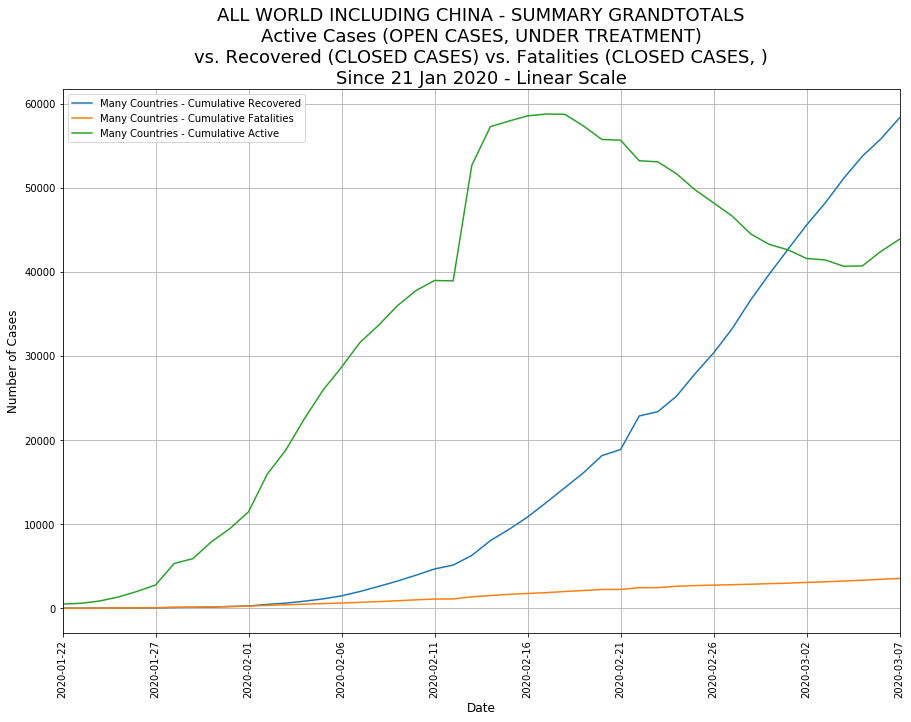

In [9]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
dict_of_dataframes['Cumulative Active'] = active_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - SUMMARY GRANDTOTALS' + \
        '\n' + \
        'Active Cases (OPEN CASES, UNDER TREATMENT)' + \
        '\n' + \
        'vs. Recovered (CLOSED CASES) vs. Fatalities (CLOSED CASES, )' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

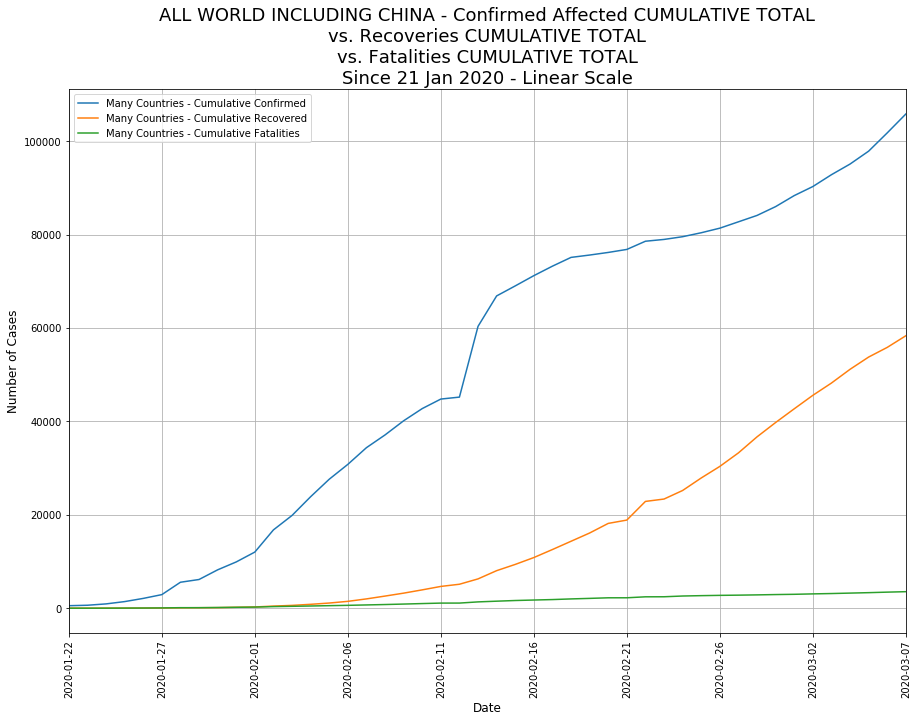

In [10]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

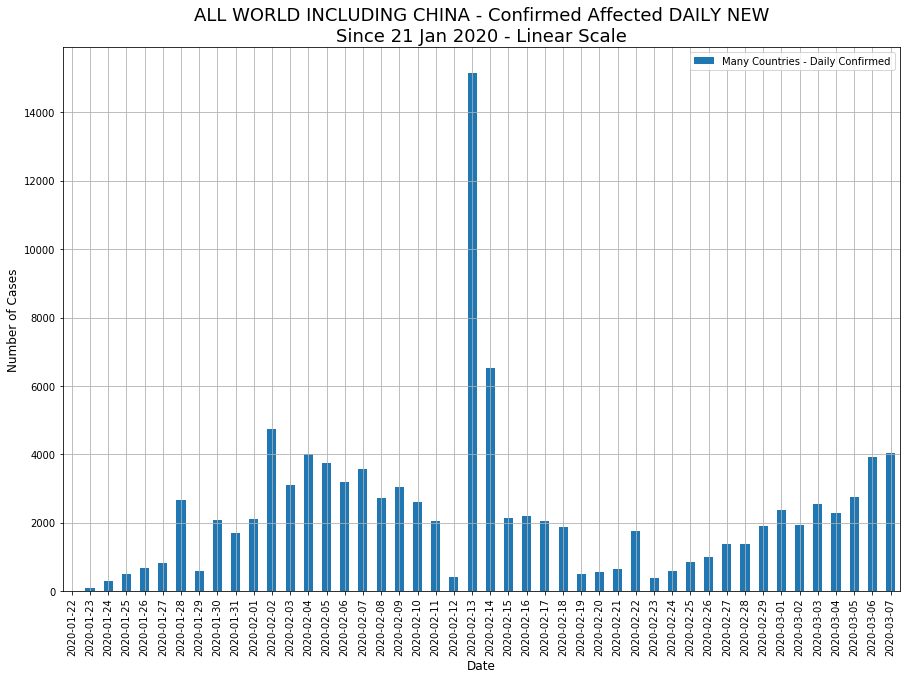

In [11]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

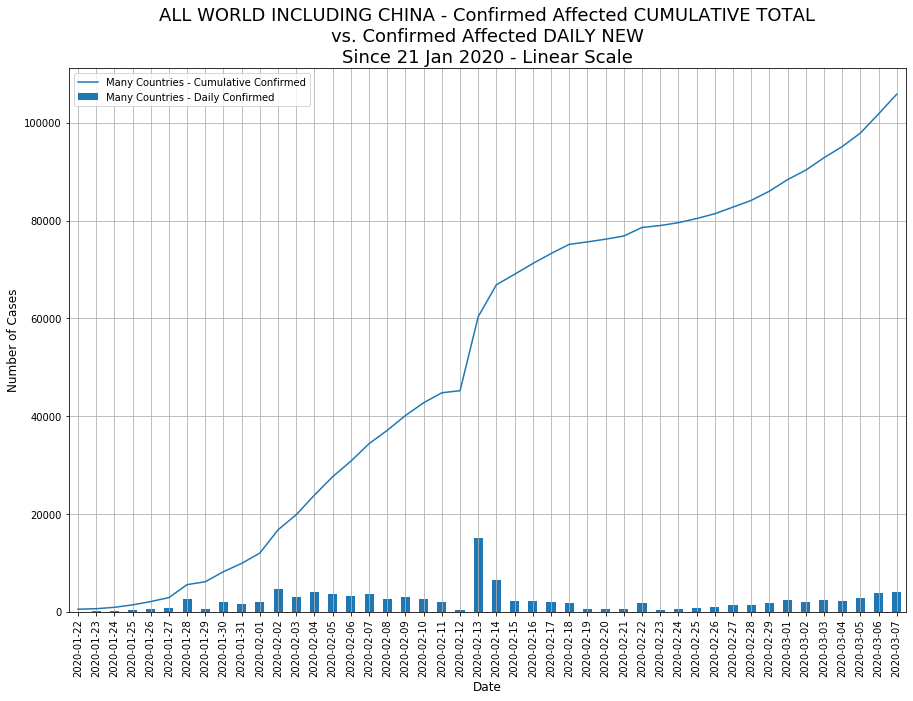

In [12]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

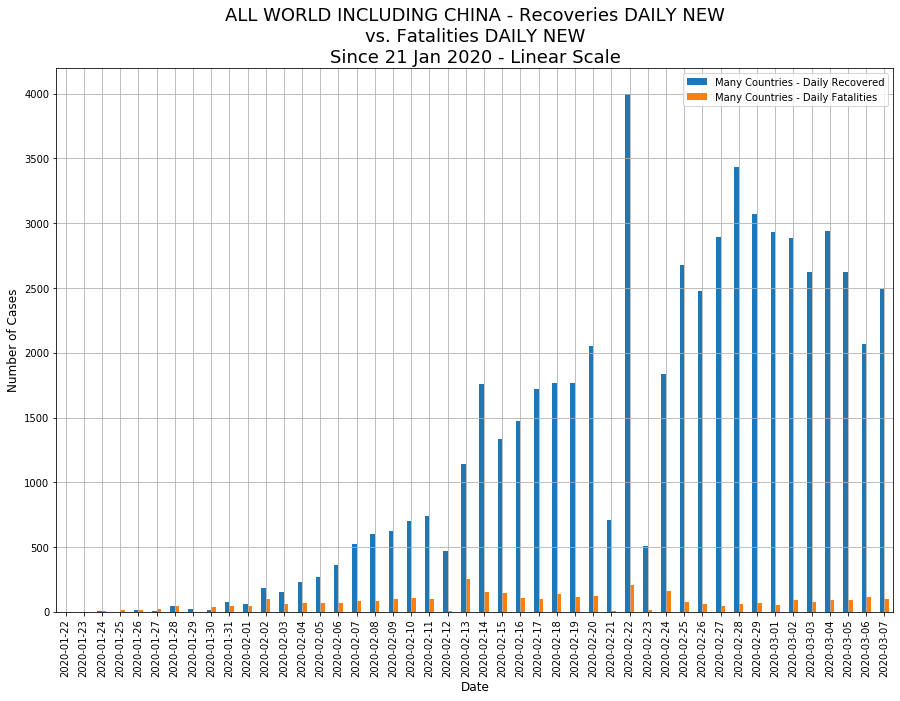

In [13]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

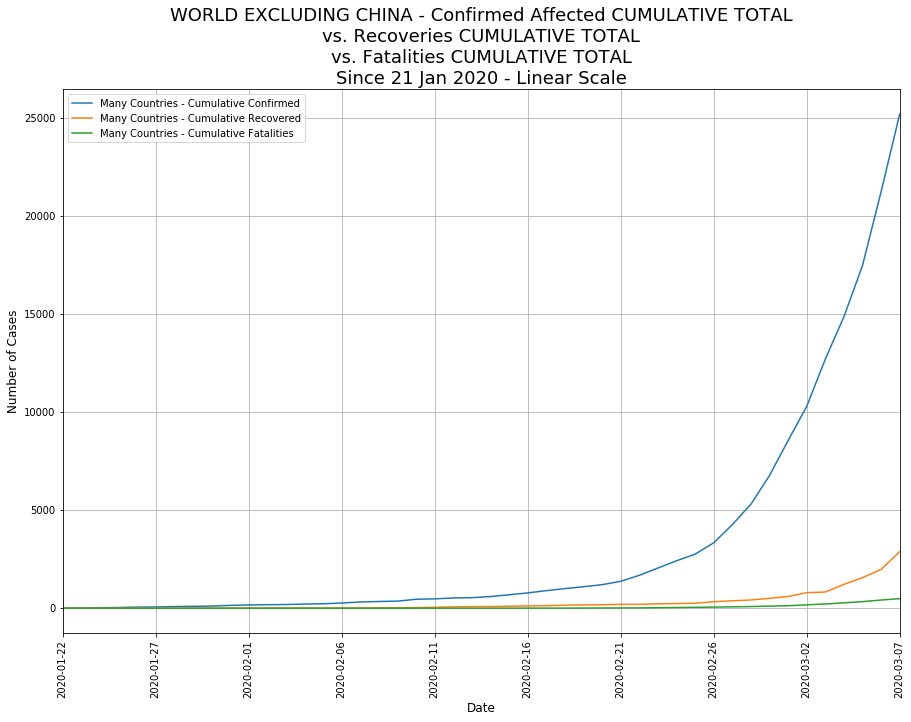

In [14]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

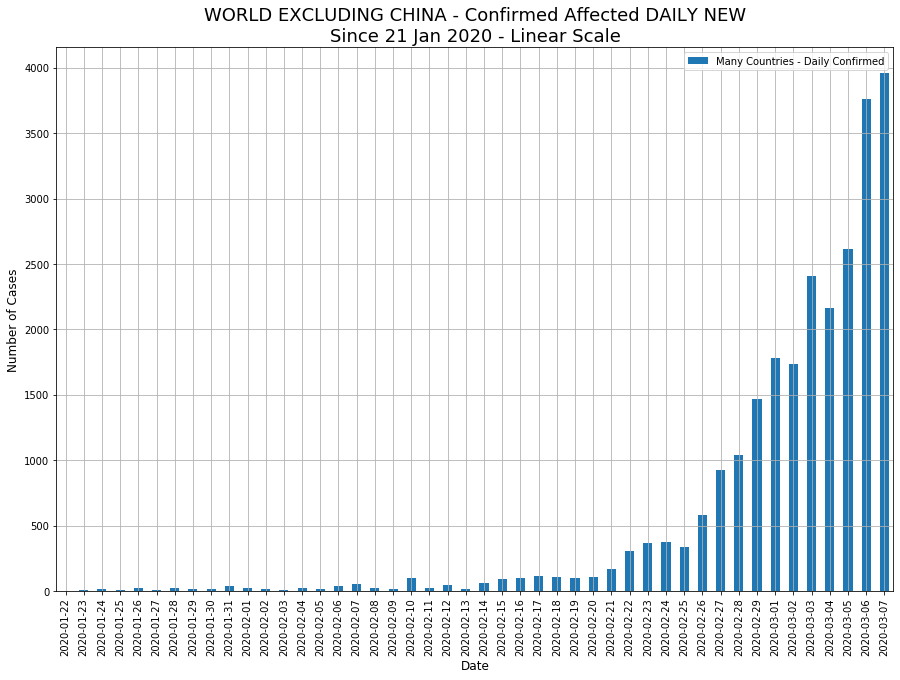

In [15]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

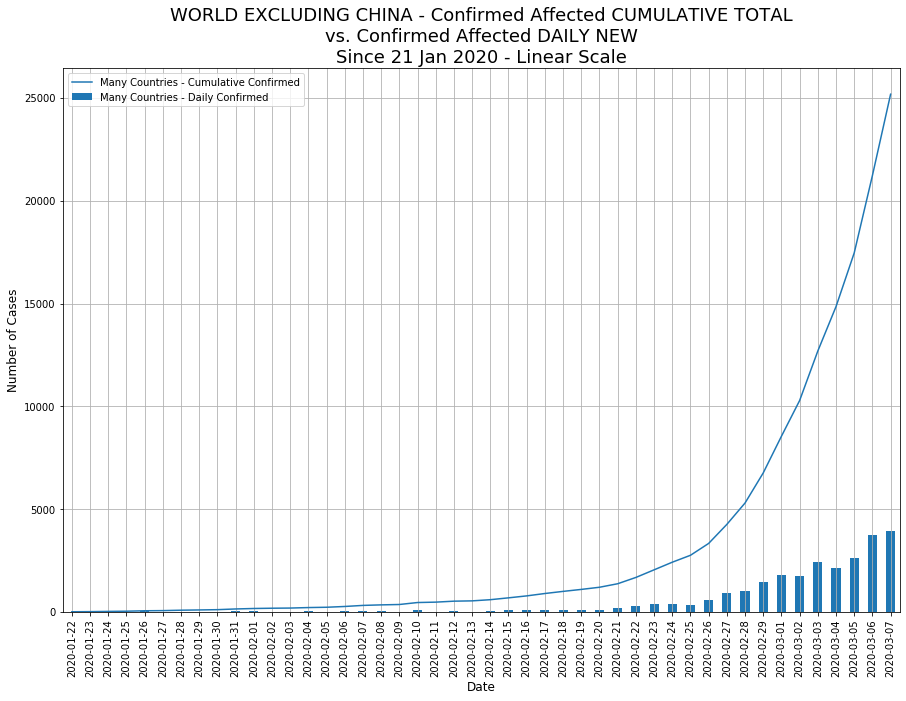

In [16]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

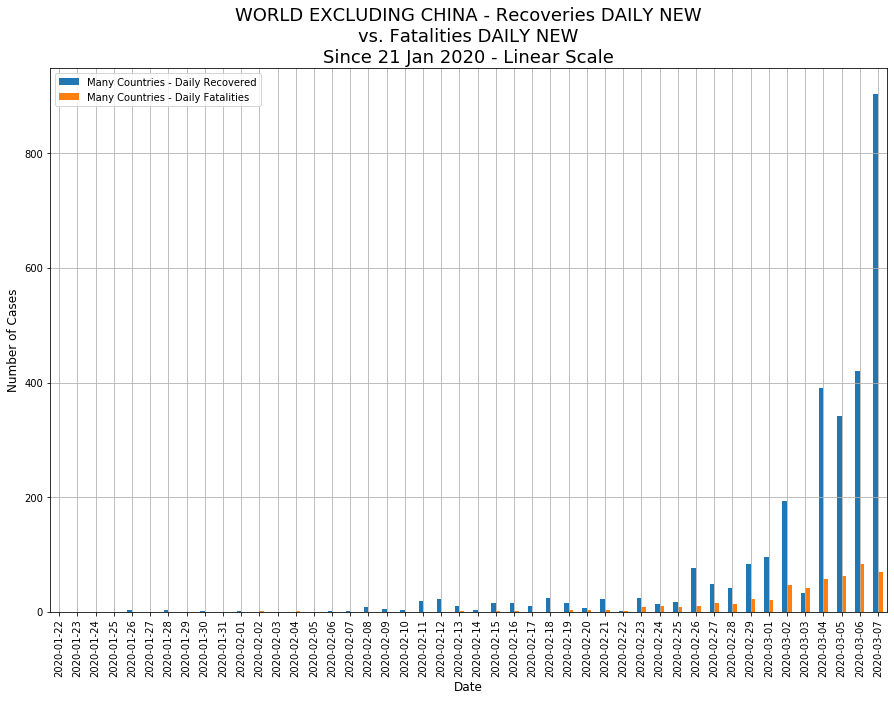

In [17]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

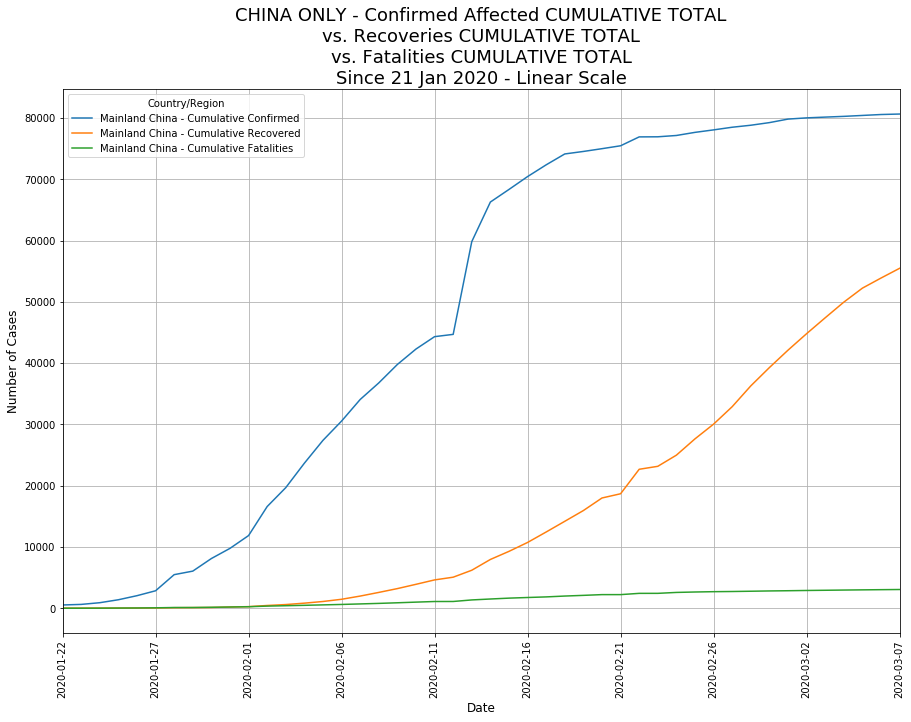

In [18]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Mainland China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

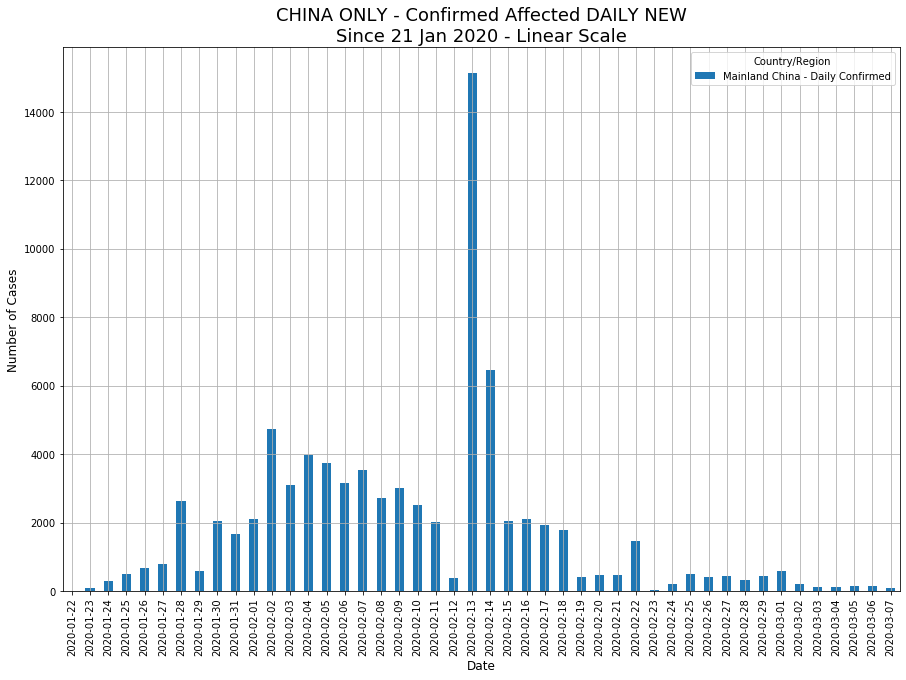

In [19]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Mainland China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

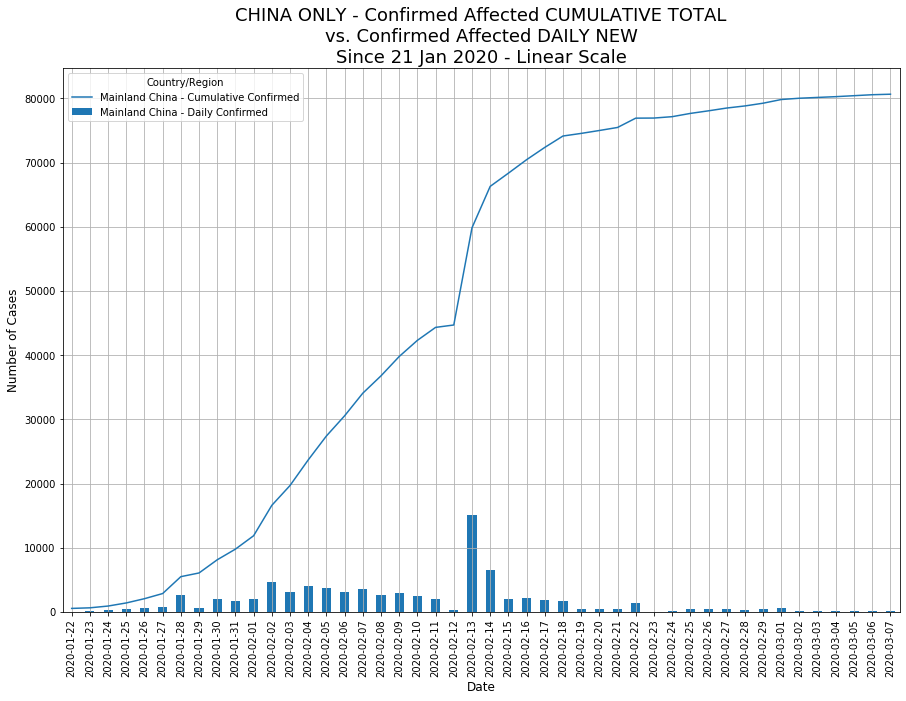

In [20]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Mainland China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

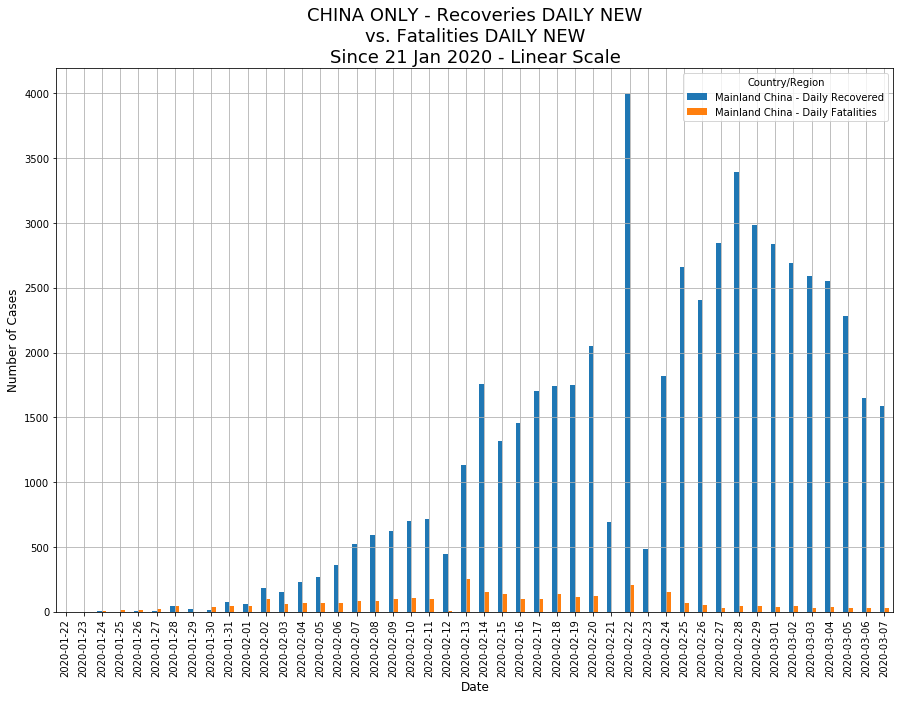

In [21]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Mainland China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

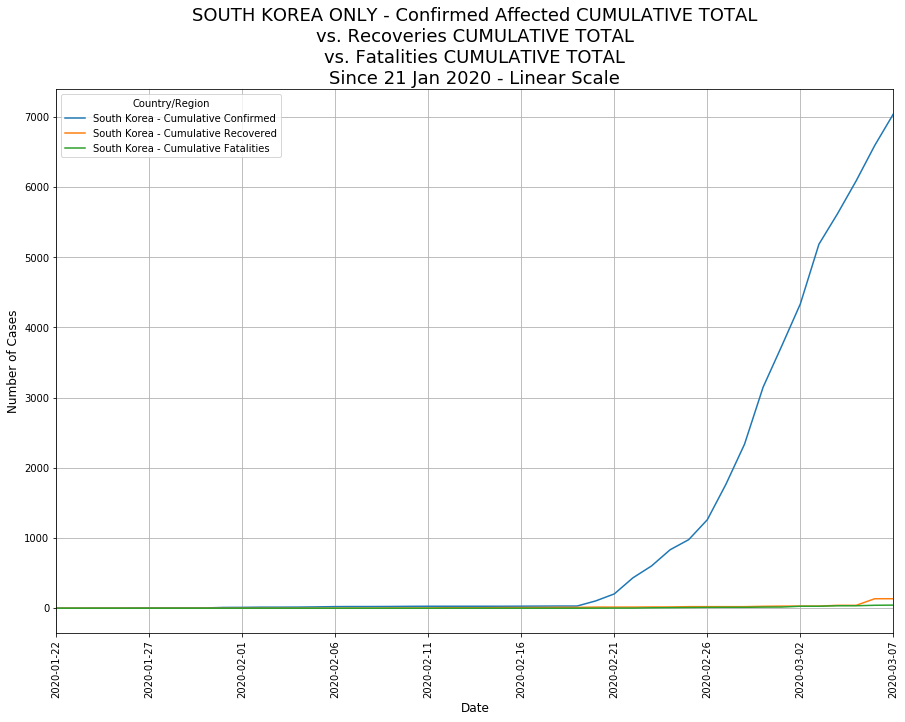

In [22]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['South Korea']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

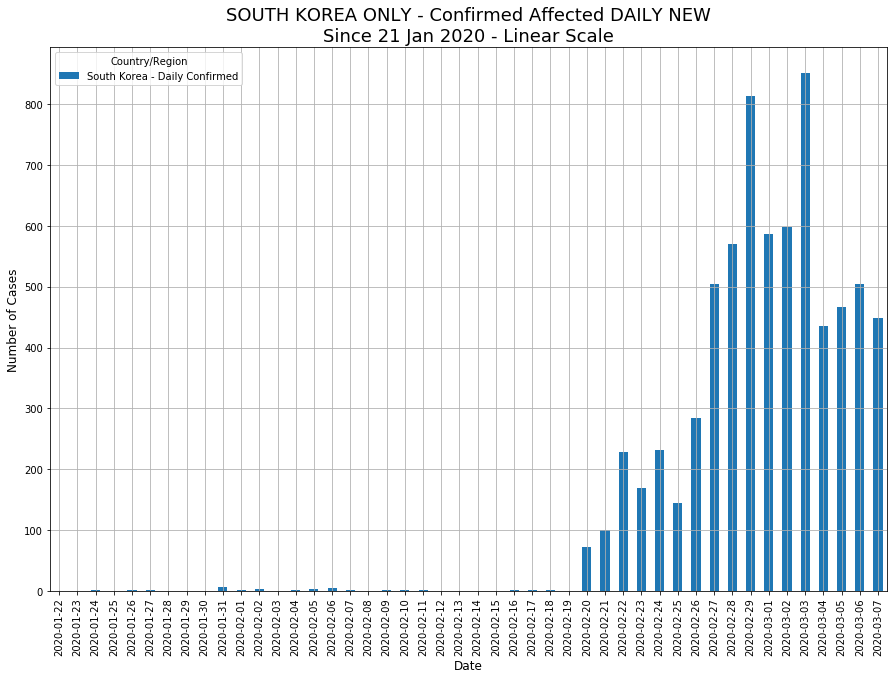

In [23]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['South Korea']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

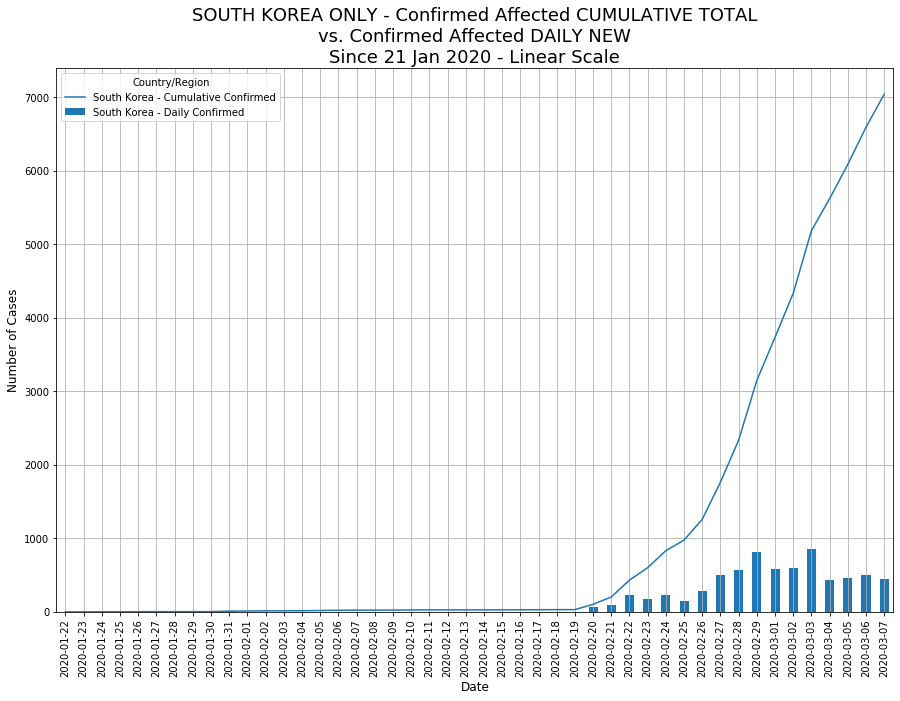

In [24]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['South Korea']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

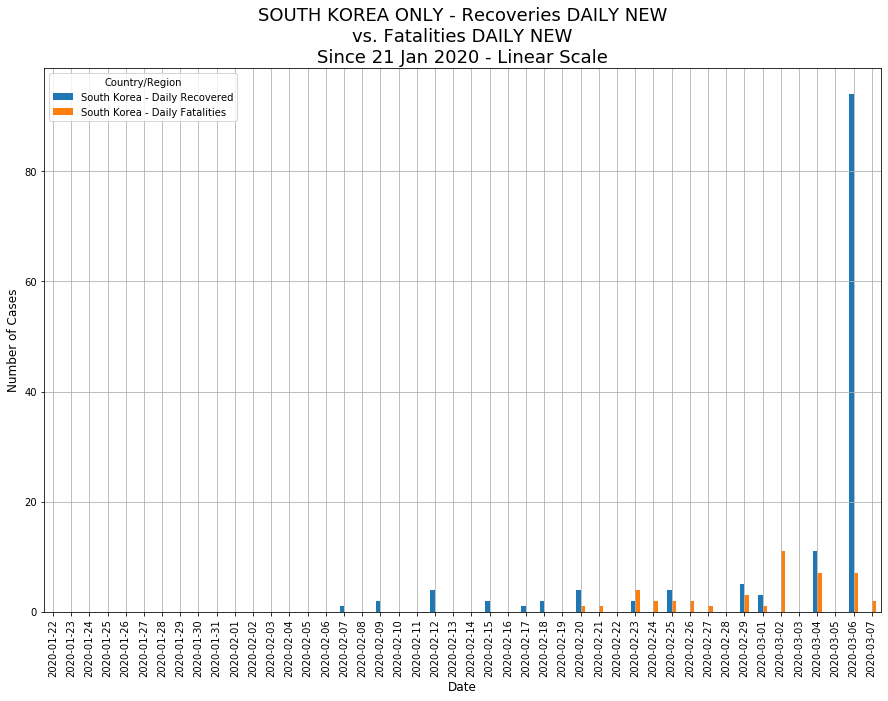

In [25]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['South Korea']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

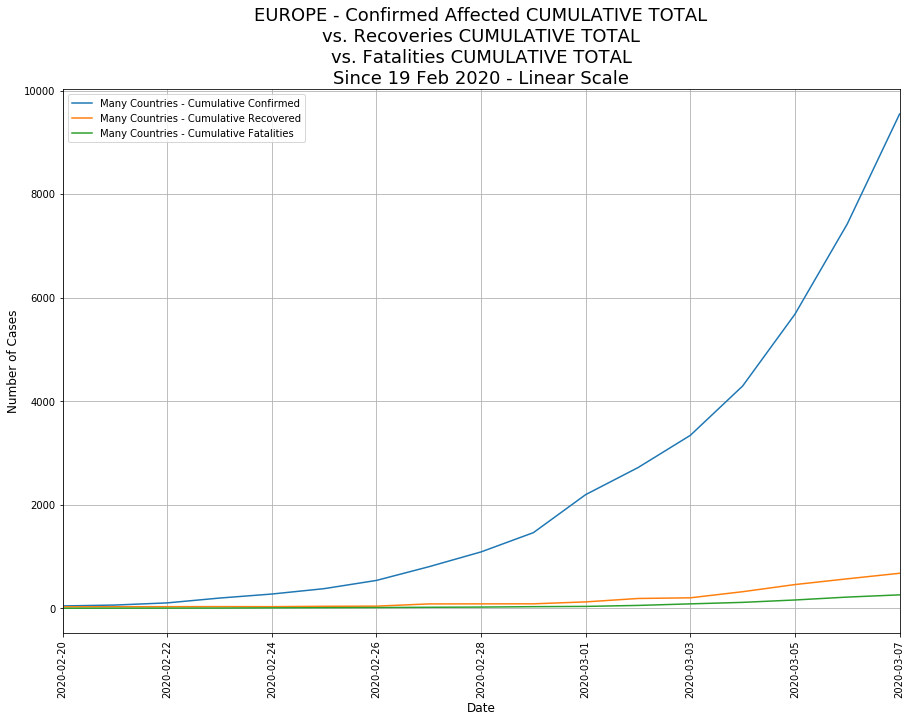

In [26]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

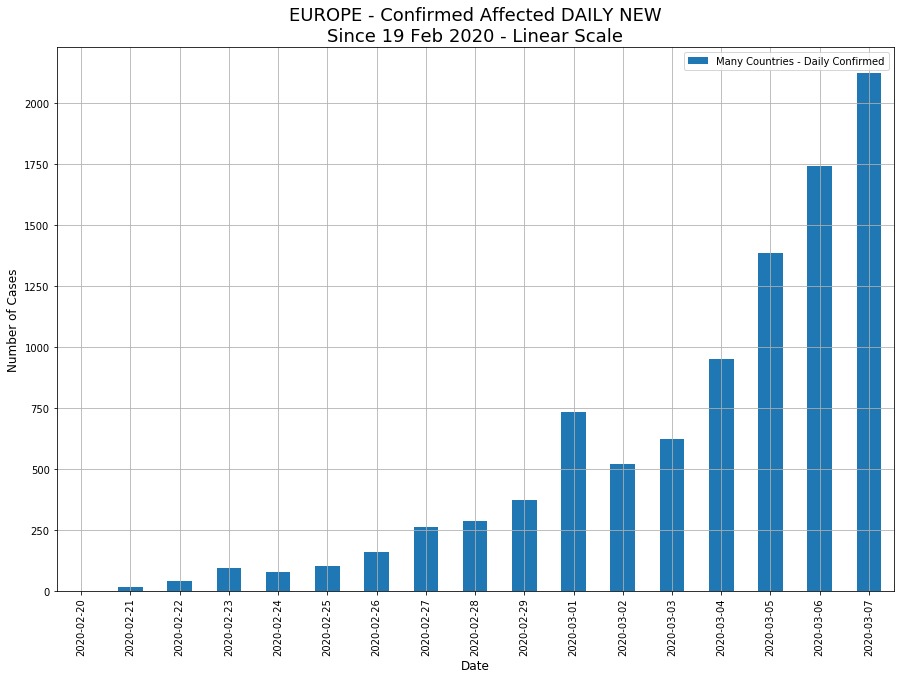

In [27]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

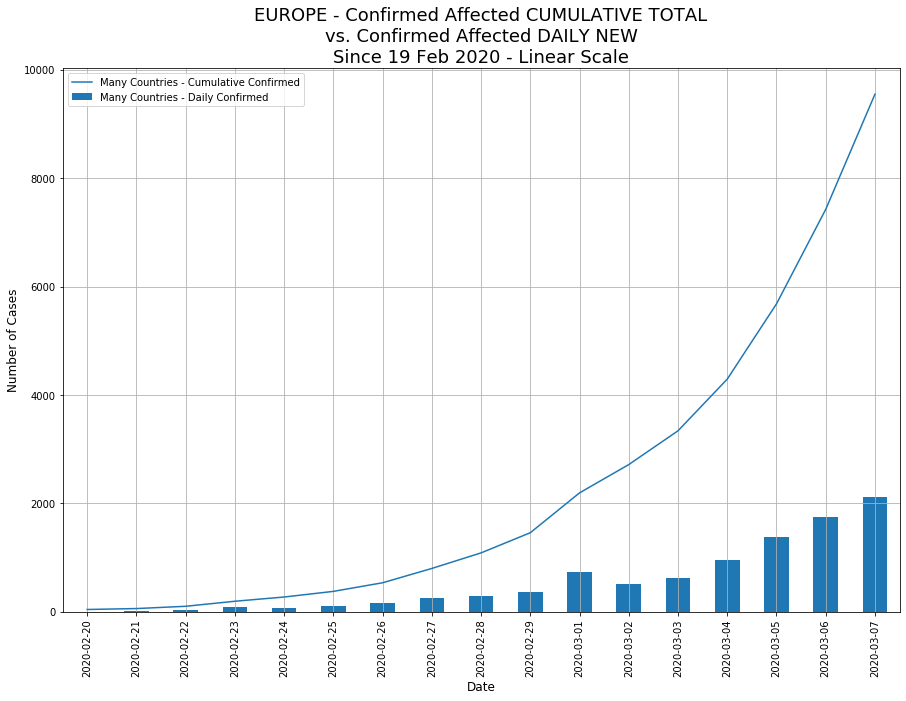

In [28]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

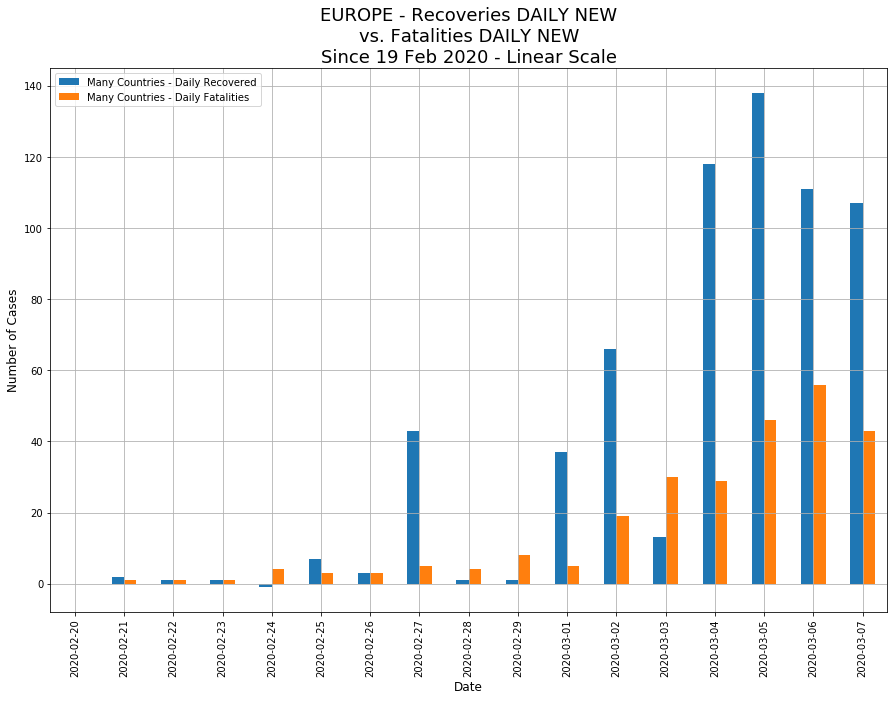

In [29]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

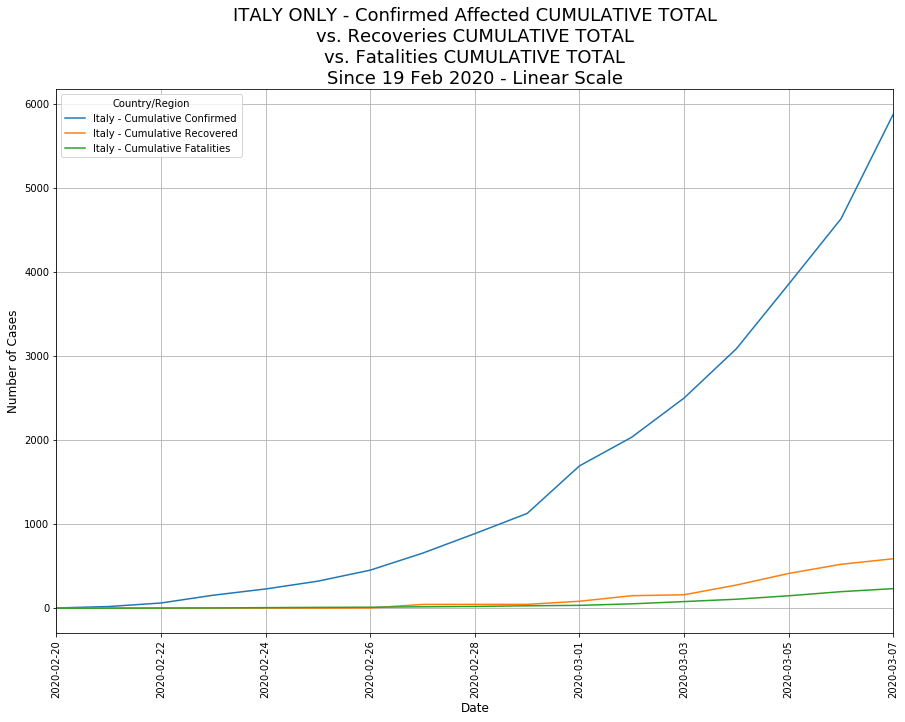

In [30]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

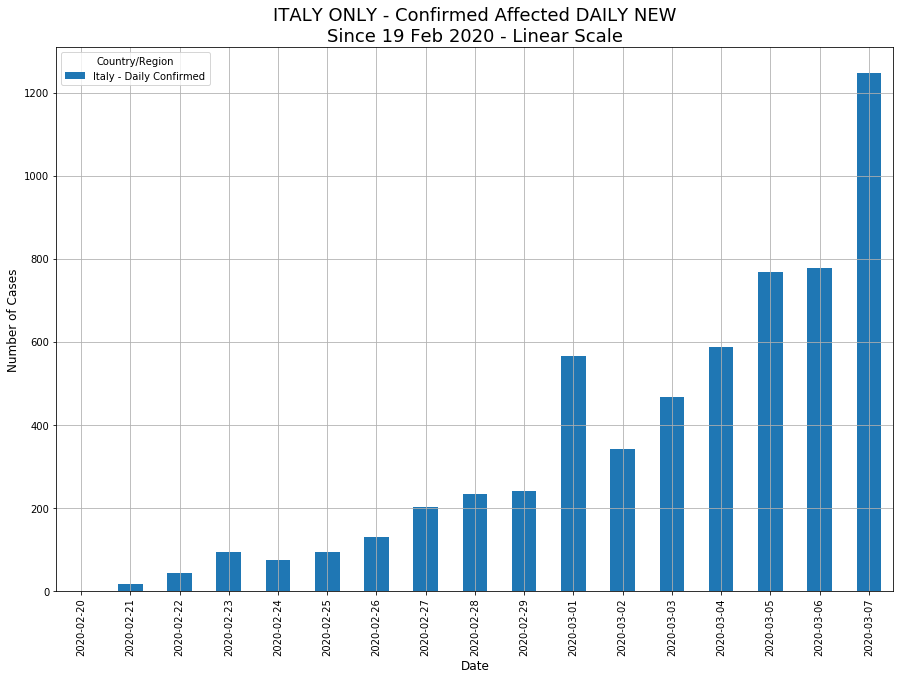

In [31]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

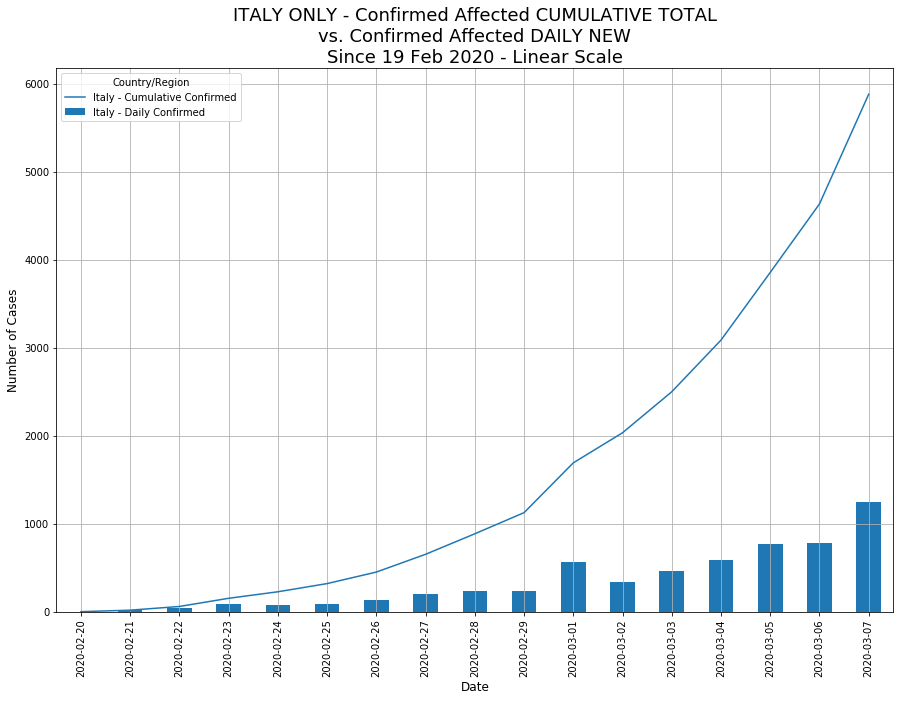

In [32]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

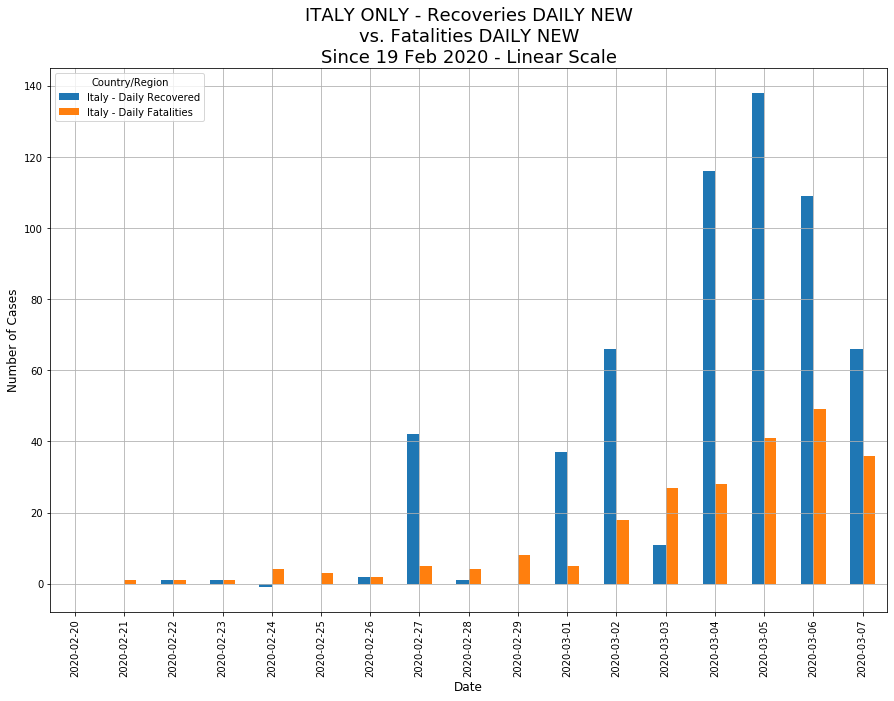

In [33]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

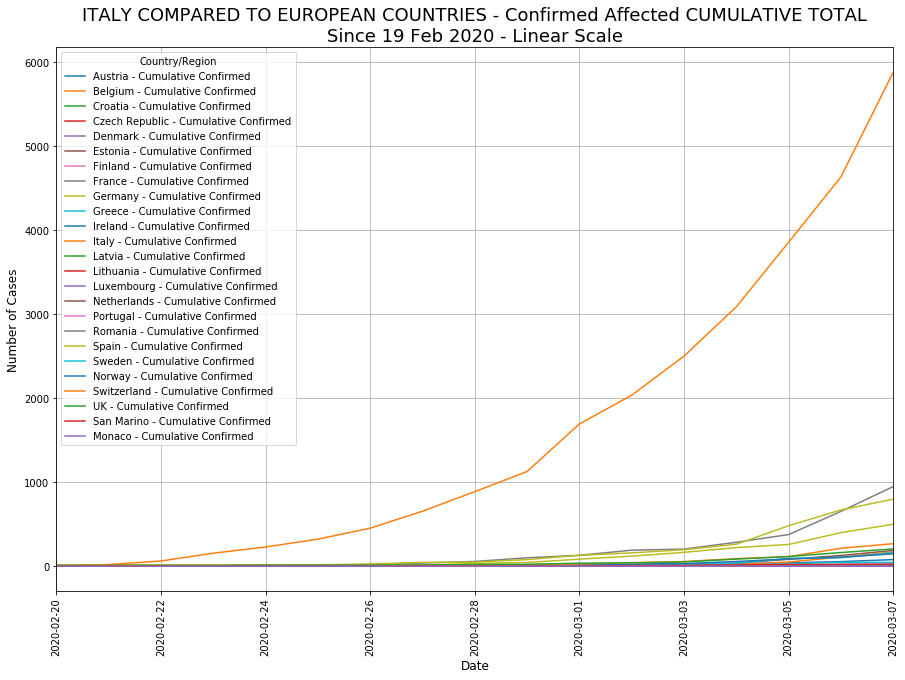

In [34]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY COMPARED TO EUROPEAN COUNTRIES - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

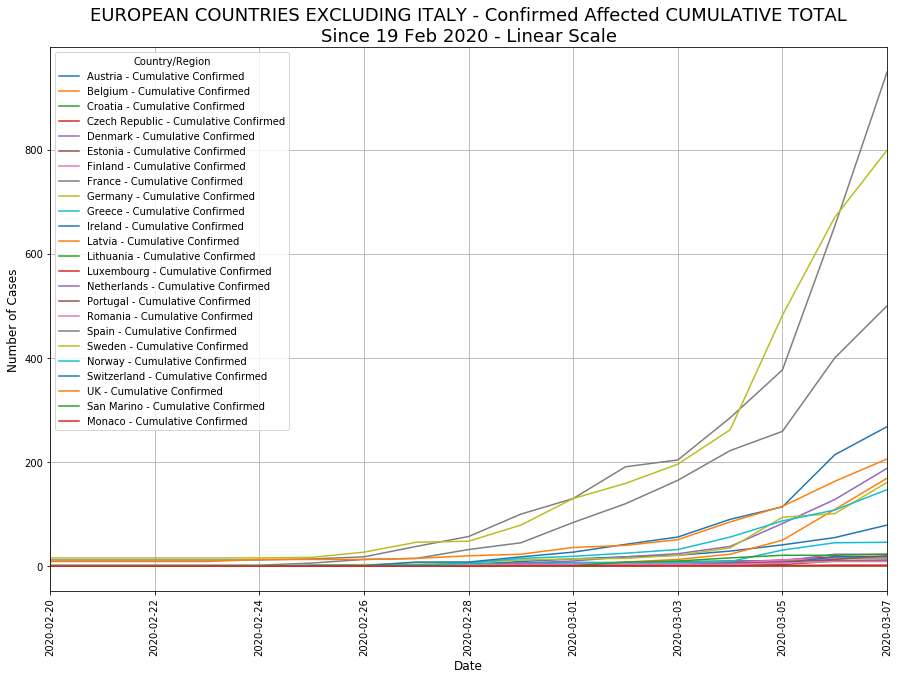

In [35]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe_noitaly

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

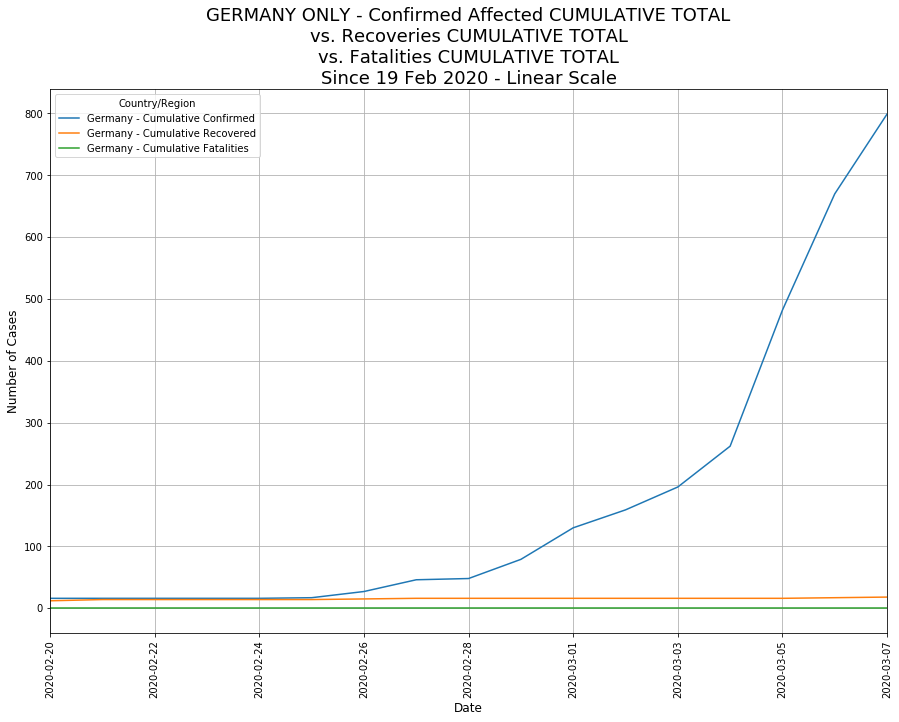

In [36]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

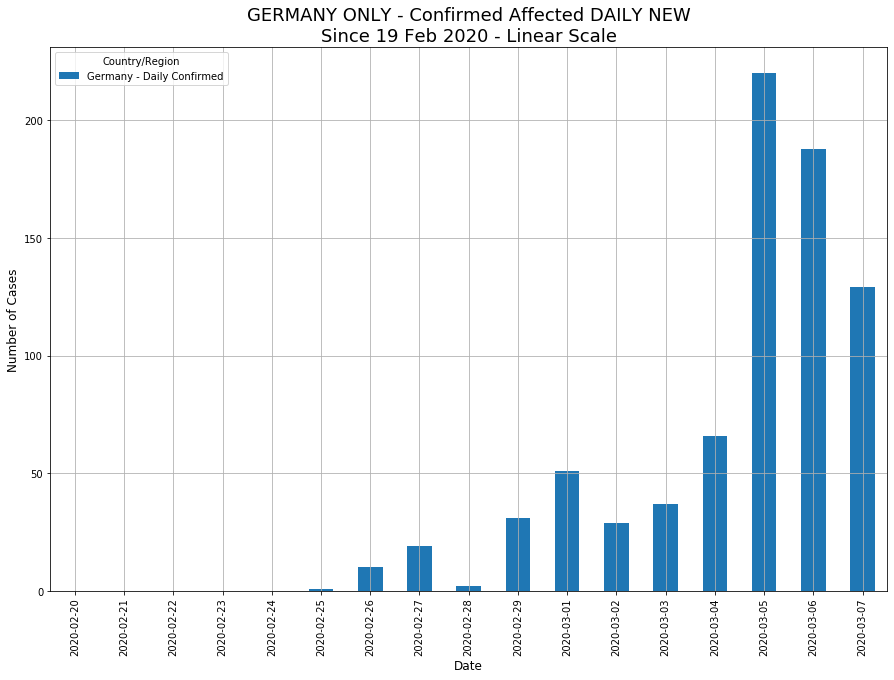

In [37]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

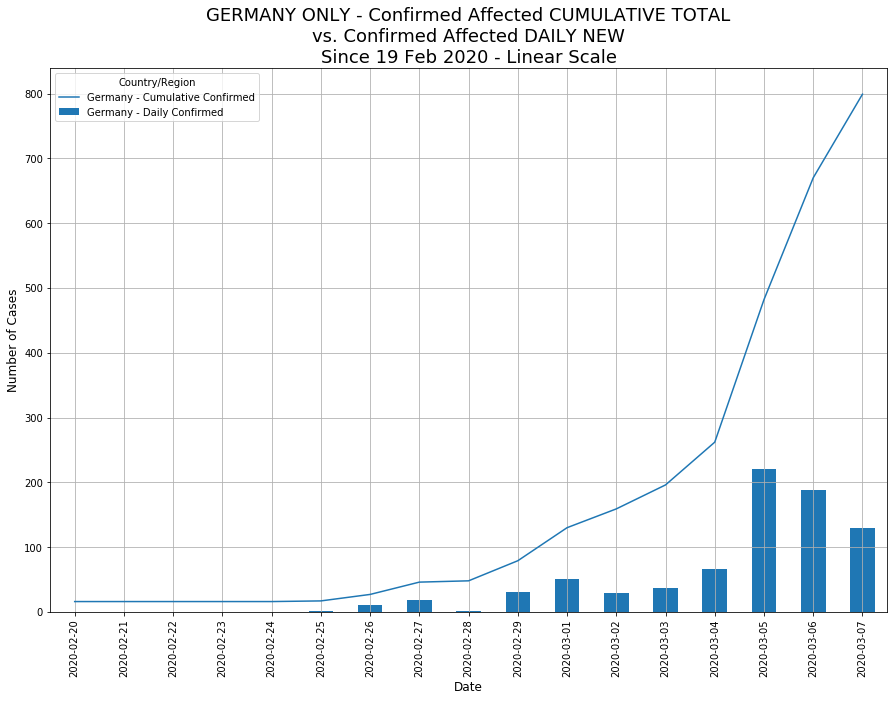

In [38]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

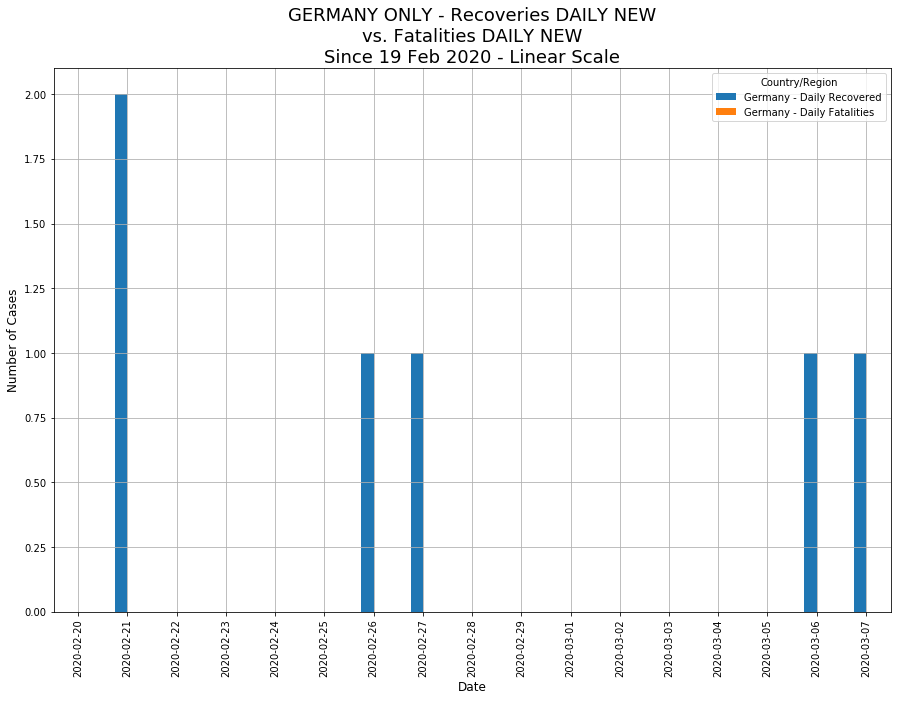

In [39]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

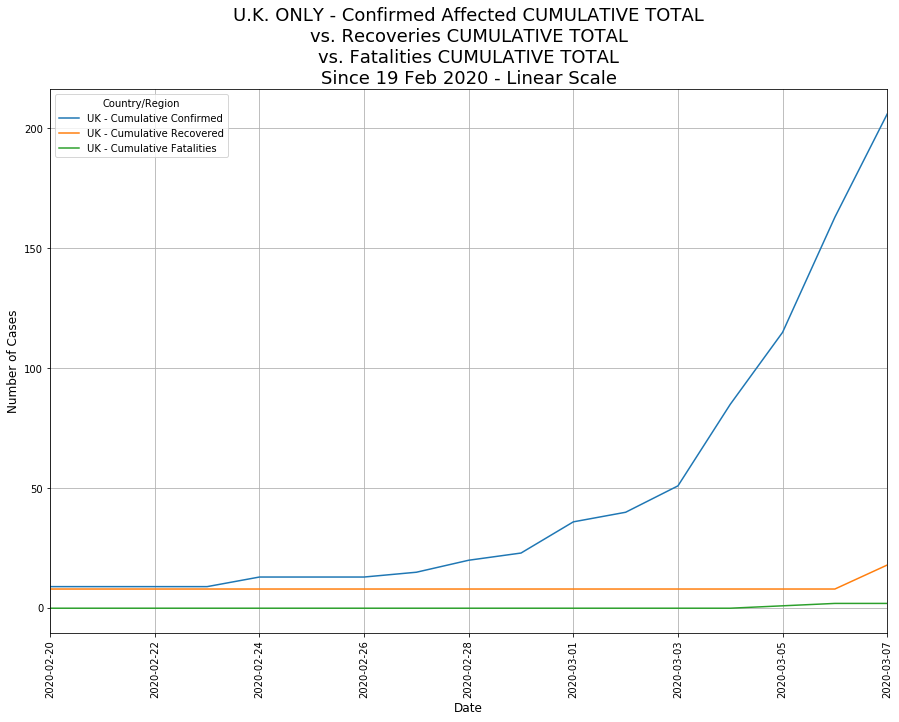

In [40]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['UK']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

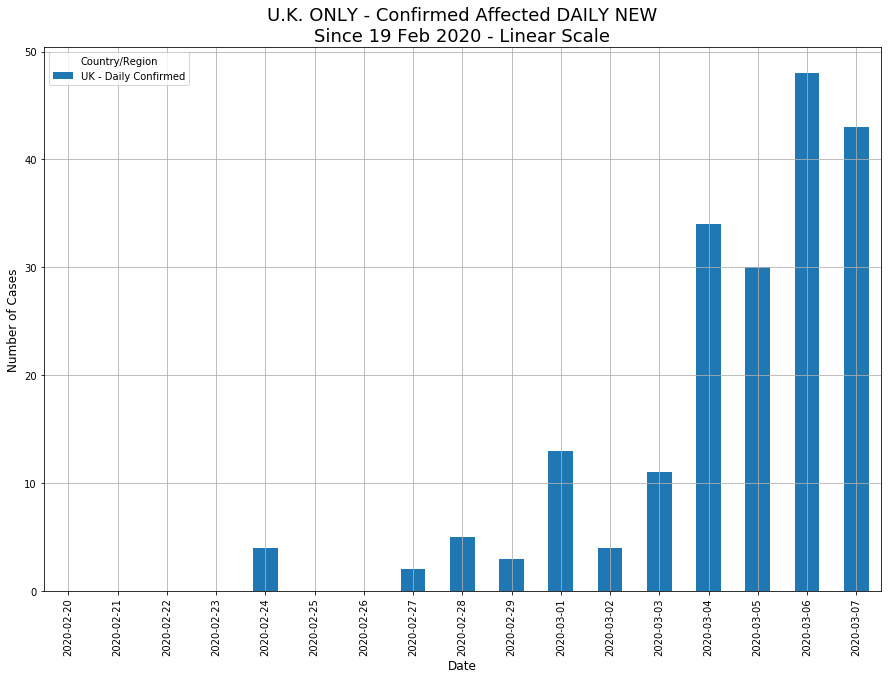

In [41]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['UK']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K. ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

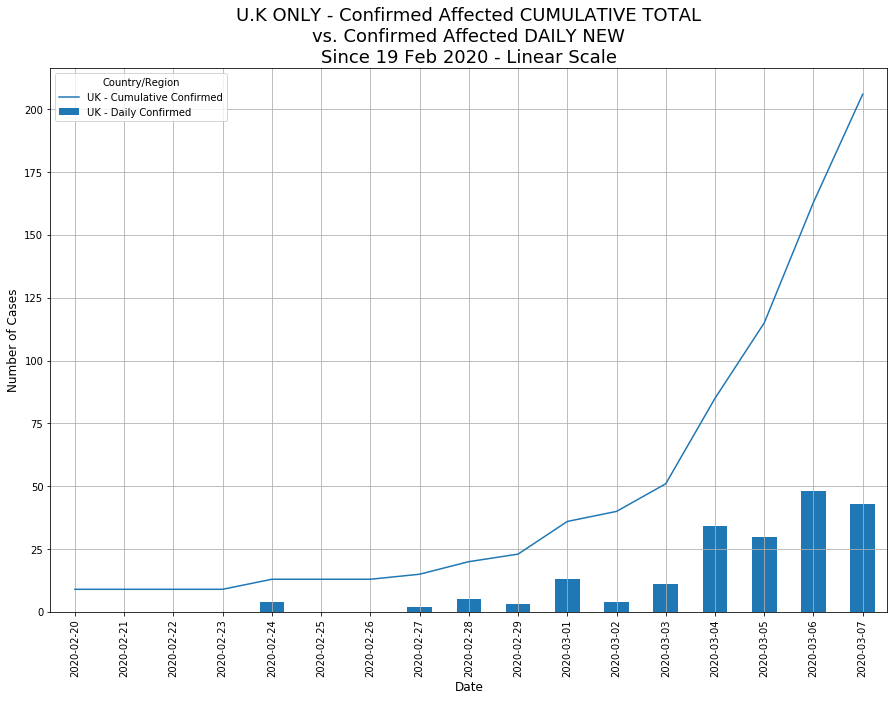

In [42]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['UK']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

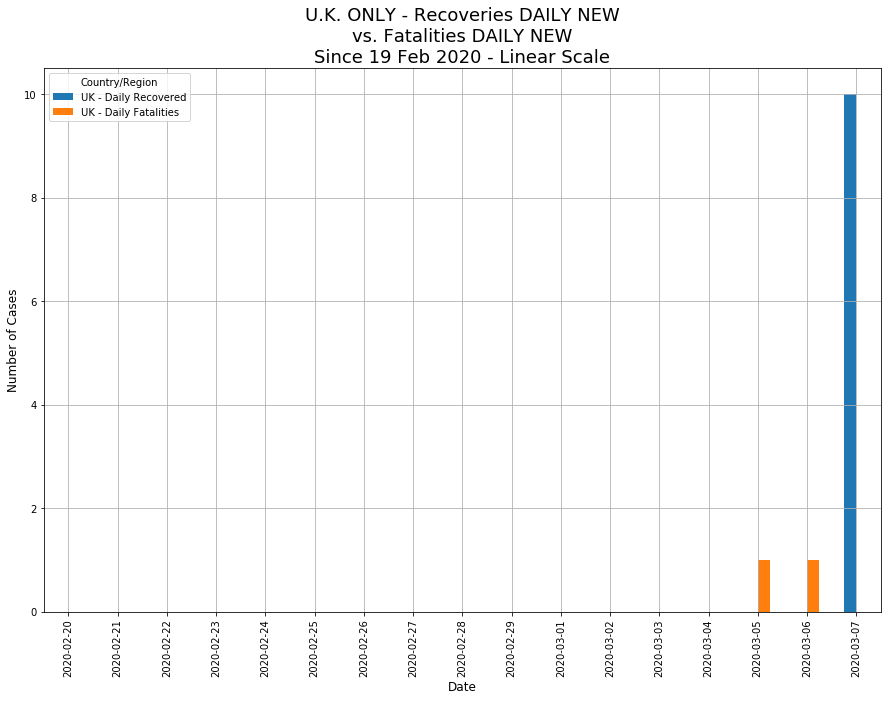

In [43]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['UK']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K. ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

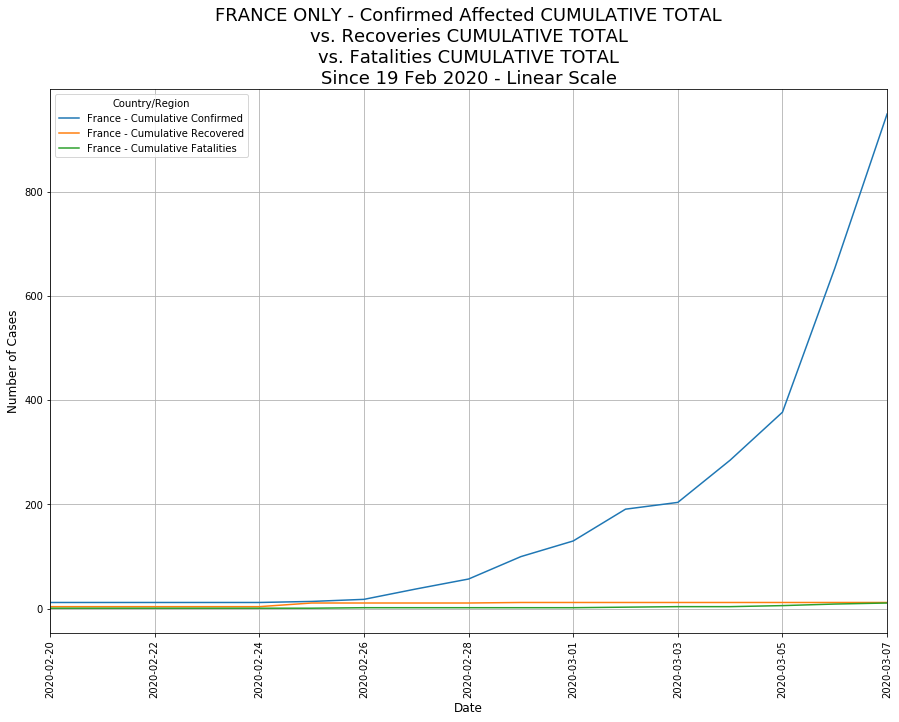

In [44]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

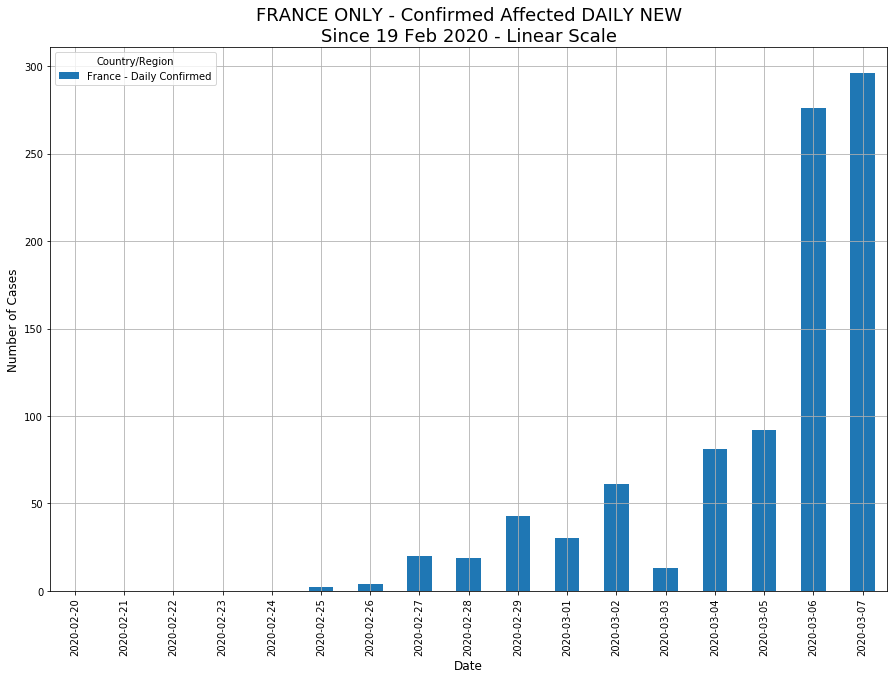

In [45]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

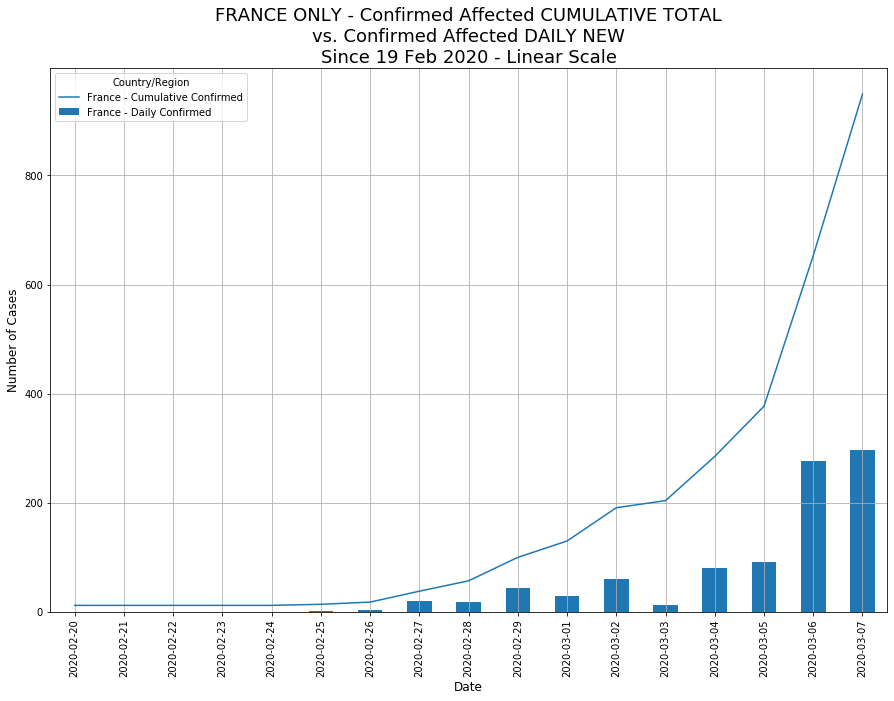

In [46]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

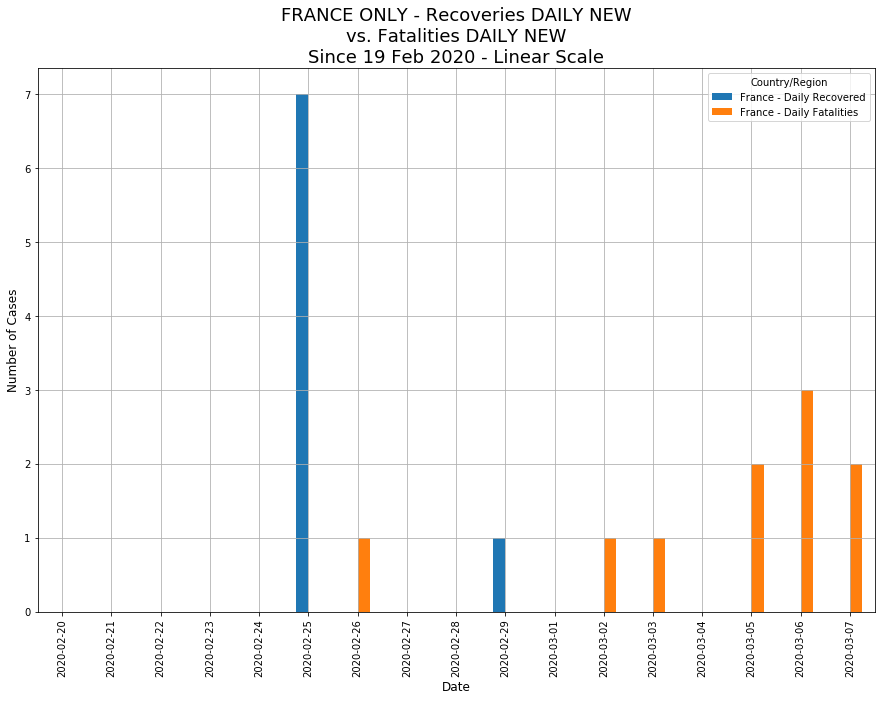

In [47]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

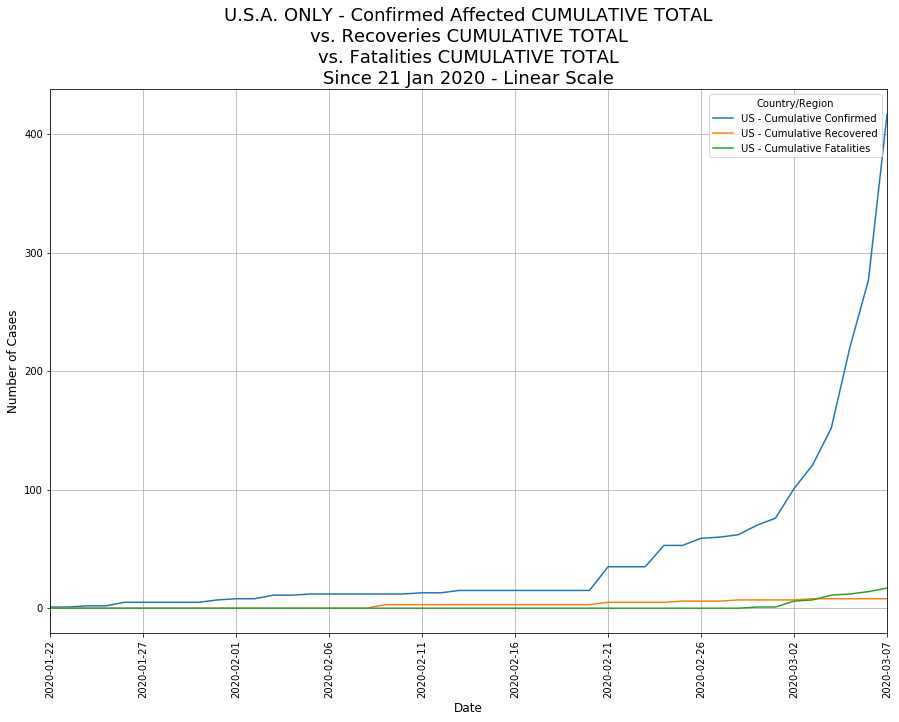

In [48]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

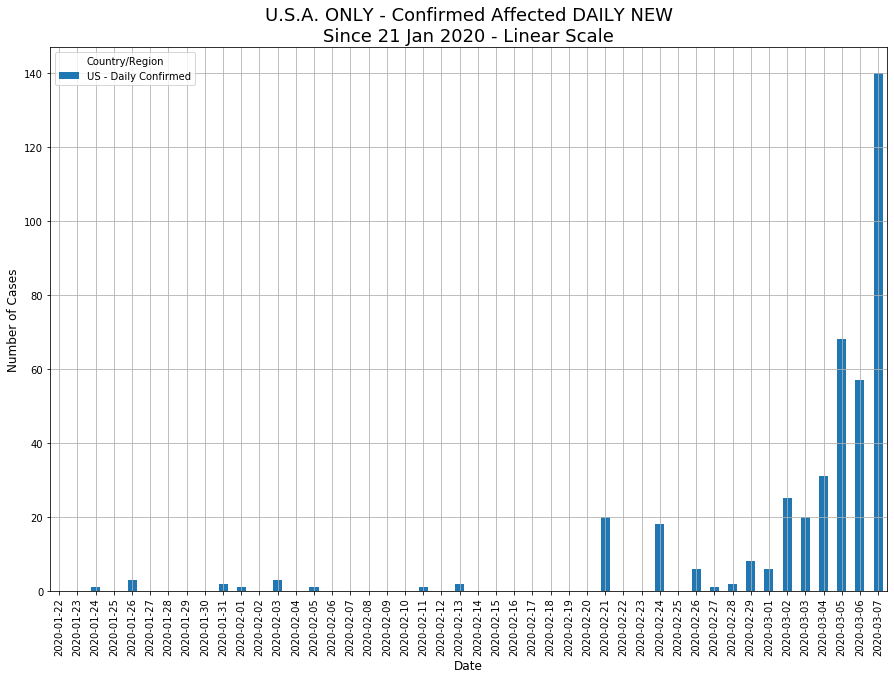

In [49]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

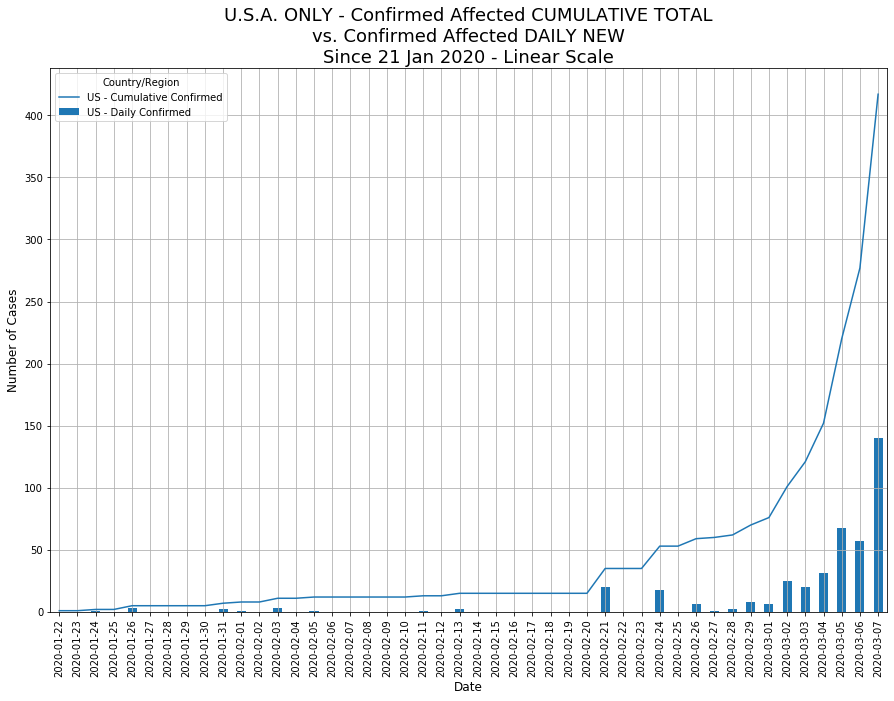

In [50]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

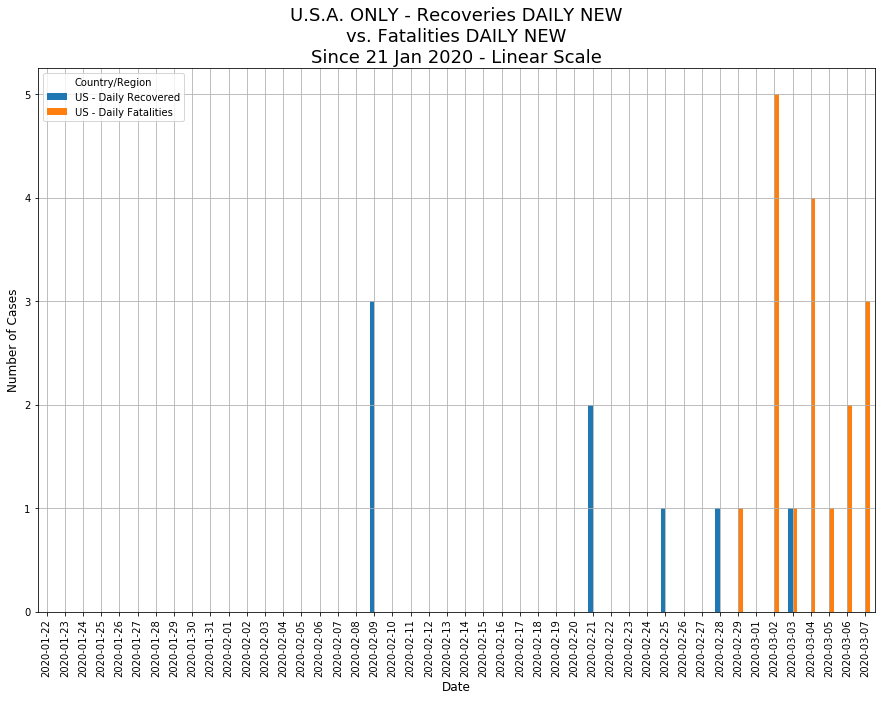

In [51]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

In [52]:
# GENERATES "index.html" PAGE IN "./charts" TO SHOW SAVED CHARTS ON BROWSER

now = datetime.now()
last_updated = now.strftime("%d %b, %Y - %H:%M:%S")
os.chdir('charts')

html_str = """<!DOCTYPE html>
<html>
<head>
  <meta charset='UTF-8'>
  <title>COVID-19 Charts</title>
</head>
<body>
<font face='Impact' size='3' color='black'>
<h1>COVID-19 Charts - Last updated """ + last_updated + """ (CET)</h1>
</font>
<p>
<b>Data Source Reference:</b><br>
2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE:
<br>
<a href='https://github.com/CSSEGISandData/COVID-19'>https://github.com/CSSEGISandData/COVID-19</a>
</p>
<p>
<b>Terms of use:</b><br>
Please see the Terms of Use extensively described at the above link for reference
</p>
<p>
<b>Disclaimer:</b><br>
This Website, the related GitHub repo and its contents, including all data, mapping, and analysis is provided to the public strictly for educational and academic research purposes. It is hereby disclaimed any and all representations and warranties with respect to the Website and related Git Repo, including accuracy, fitness for use, and merchantability. Reliance on the Website for medical guidance or use of the Website in commerce is strictly prohibited.
</p>
<p>
<b>GitHub Repository:</b><br>
Please visit the GitHub Repository containing the full source code (Jupyter Notebook) used to generate the charts:
<br>
<a href='https://github.com/r-lomba/covid-19-charts'>https://github.com/r-lomba/covid-19-charts</a>
</p>
<p>
<b>Contacts:</b><br>
You can contact me here:
<br>
<a href='mailto:r.lombardelli@digitalgarage.it'>r.lombardelli@digitalgarage.it</a>
</p>
<hr>
<font face='Impact' size='3' color='black'>
<h1 align='center'>The World at a glance - Grandtotals Summary - """ + last_updated + """ (CET)</h1>
</font>
<table border=0>"""

i = 0

for file in sorted(filter(os.path.isfile, os.listdir('.')), key=os.path.getmtime):
    filename = os.fsdecode(file)
    if filename.endswith('.png'): 
        html_str = html_str + "<tr><img src='" + filename.replace(' ', '%20') + "'></tr>"
        
        if (i == 0): # COMMENTS TO THE SUMMARY CHART
            i = 1
            html_str += "<tr bgcolor='cyan'><br><br><br><br><font face='Arial' size='3' color='black'><h3 aligh='center'>Highlight of the chart just below: It's interesting to notice that Recoveries surpassed Active Cases at the beginning of March. Active Cases rising again in number since 5th of March, though</b></h3></font><br></tr>"

html_str += "</table></body></html>"

Html_file= open('./index.html','w')
Html_file.write(html_str)
Html_file.close()

os.chdir('..')